In [4]:
#Import all the necessary python libraries
import os
import pandas as pd
import numpy as np

import json
import pymzml
import csv
import re
from tqdm import tqdm

import warnings

import plotly.graph_objs as go
from scipy.integrate import trapz
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture


#######################################
### FIX AND DOUBLE CHECK LATER#######
#################################
#CLAW made directories 
import create_directory
import CLAW
import OzESI_CLAW
# import OzESI
# import OzESI_plot
# import OzESI_compare

#version 2
import OzESI
from OzESI_plot import Plot
# Import the create_folder function from OzESI_utils
from OzESI_utils import create_folder, create_base_directory, generate_filename, save_for_ozone_compare, create_project_folder, filter_o3mzml_files, create_all_folders
from OzESI_compare import OzoneCompare

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Set Directories to load and save

In [5]:


# Define the mode: 'ON' or 'OFF'
mode = 'ON'  # Change to 'ON' as needed

# Project Directory
project = './Projects/'

# Project Name
project_name = 'AMP' #name of project
project_data_name = 'AMP' #name of data from project

project_folder_data = f'{project}{project_name}/AMP_ON/'
project_results_folder = f'{project}{project_name}/results/'

#mzML Data
mzml_data = f'{project}{project_name}/mzml/parse_test/' #mzML Parse

#CSV Data
csv_data_folder = f'{project_results_folder}csv_data/'


grouped_data_csv = f"{csv_data_folder}{project_data_name}_LipidGrouper_{mode}.csv" # Save RawDataParser output CSV file
matched_data_csv = f"{csv_data_folder}{project_data_name}_MatchedData_{mode}.csv" # Save MatchedData output CSV file
peak_analysis_csv = f"{csv_data_folder}{project_data_name}_PeakAnalysis_{mode}.csv" # Path to the PeakAnalysis output CSV file

#dont need?
# # Paths to the CSV files
# mrm_csv_path = f'{csv_data_folder}df_MRM_{mode}.csv'
# oze_esi_csv_path = f'{csv_data_folder}df_OzESI_{mode}.csv'

#plot data
plots_directory = f'Projects/{project_name}/results/{project_data_name}/plots/on/'

#Database Locations
OzON_database = 'lipid_database/OzON_databases/OzON_Possible_Database.csv' ##double check this is right
OzOFF_database = f'{csv_data_folder}{project_name}_OzOFF_possible.csv'



# Define all necessary folder paths
folders_to_create = [
    csv_data_folder,
    plots_directory,
    project_results_folder,
    plots_directory
]

# Call the function to ensure all folders exist
create_all_folders(*folders_to_create)



Folder already exists: ./Projects/AMP/results/csv_data/
Folder already exists: Projects/AMP/results/AMP/plots/on/
Folder already exists: ./Projects/AMP/results/
Folder already exists: Projects/AMP/results/AMP/plots/on/


### MZML PARSER

In [6]:

# class MzMLParser:
#     def __init__(self):
#         # Initialize DataFrames to store parsed data
#         self.transition_summed_df = pd.DataFrame(columns=[
#             'Parent_Ion', 
#             'Product_Ion', 
#             'Intensity', 
#             'Transition', 
#             'Sample_ID'
#         ])
#         self.OzESI_df = pd.DataFrame(columns=[
#             'Lipid',
#             'Parent_Ion', 
#             'Product_Ion', 
#             'Retention_Time', 
#             'OzESI_Intensity', 
#             'Sample_ID', 
#             'Transition'
#         ])
#         self.time_and_intensity_df = pd.DataFrame(columns=['Time', 'Intensity'])

#     def mzml_parser(self, file_path, plot_chromatogram=False):
#         """
#         Parses a single mzML file and updates the DataFrames with parsed data.

#         Parameters:
#         file_path (str): The path to the mzML file to be parsed.
#         plot_chromatogram (bool): Flag to indicate whether to plot the chromatogram (default is False).
#         """
#         rows = []
#         ozesi_rows = []

#         # Read the mzML file using pymzml
#         run = pymzml.run.Reader(file_path, skip_chromatogram=False)
#         q1_mz = 0  # Initialize Q1 mass-to-charge ratio
#         q3_mz = 0  # Initialize Q3 mass-to-charge ratio

#         # Iterate through each spectrum in the mzML file
#         for spectrum in run:
#             # Extract Q1 and Q3 values from the spectrum ID
#             for element in spectrum.ID.split(' '):
#                 if 'Q1' in element:
#                     q1 = element.split('=')
#                     q1_mz = np.round(float(q1[1]), 1)

#                 if 'Q3' in element:
#                     q3 = element.split('=')
#                     q3_mz = np.round(float(q3[1]), 1)

#                     # Calculate the sum of intensities for the peaks in the spectrum
#                     intensity_store = np.array([intensity for _, intensity in spectrum.peaks()])
#                     intensity_sum = np.sum(intensity_store)

#                     # Construct the transition string
#                     transition = f"{q1_mz} -> {q3_mz}"
#                     # Extract sample ID from the file name
#                     sample_id = os.path.basename(file_path)[:-5]

#                     # Append parsed data to the rows list
#                     rows.append({
#                         'Parent_Ion': q1_mz,
#                         'Product_Ion': q3_mz,
#                         'Intensity': intensity_sum,
#                         'Transition': transition,
#                         'Sample_ID': sample_id
#                     })

#                     # Append time and intensity data to ozesi_rows list
#                     for time, intensity in spectrum.peaks():
#                         ozesi_rows.append({
#                             'Parent_Ion': q1_mz,
#                             'Product_Ion': q3_mz,
#                             'Retention_Time': time,
#                             'OzESI_Intensity': intensity,
#                             'Sample_ID': sample_id,
#                             'Transition': transition
#                         })

#         # Convert rows list to a DataFrame and append it to transition_summed_df
#         df = pd.DataFrame(rows)
#         self.OzESI_df = self.OzESI_df.append(pd.DataFrame(ozesi_rows), ignore_index=True)
#         self.transition_summed_df = self.transition_summed_df.append(df, ignore_index=True)
#         print(f'Finished parsing mzML file: {file_path}\n')

#     def mzml_parser_batch(self, folder_name, plot_chromatogram=False):
#         """
#         Parses all mzML files in a given directory and updates the DataFrames.

#         Parameters:
#         folder_name (str): The path to the directory containing mzML files.
#         plot_chromatogram (bool): Flag to indicate whether to plot the chromatogram (default is False).
#         """
#         # List all files in the directory and sort them
#         data_folder = os.listdir(folder_name)
#         data_folder.sort()

#         # Iterate through each file in the directory
#         for file in data_folder:
#             # Process only mzML files
#             if file.endswith('.mzML'):
#                 file_path = os.path.join(folder_name, file)
#                 self.mzml_parser(file_path, plot_chromatogram=plot_chromatogram)

#         print('Finished parsing all mzML files\n')

#     def get_transition_summed_df(self):
#         """
#         Returns the DataFrame containing the summed transition data.

#         Returns:
#         pd.DataFrame: The transition_summed_df DataFrame.
#         """
#         return self.transition_summed_df

#     def get_OzESI_df(self):
#         """
#         Returns the DataFrame containing the OzESI data.

#         Returns:
#         pd.DataFrame: The OzESI_df DataFrame.
#         """
#         return self.OzESI_df

# # Example usage:

# parser = MzMLParser()
# parser.mzml_parser_batch(mzml_data)

# # To view the DataFrames
# transition_summed_df = parser.get_transition_summed_df()
# OzESI_df = parser.get_OzESI_df()

# print(transition_summed_df)
# print(OzESI_df)


# MZML parser added tqdm

In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pymzml
import os

class MzMLParser:
    def __init__(self):
        # Initialize DataFrames to store parsed data
        self.transition_summed_df = pd.DataFrame(columns=[
            'Parent_Ion', 
            'Product_Ion', 
            'Intensity', 
            'Transition', 
            'Sample_ID'
        ])
        self.OzESI_df = pd.DataFrame(columns=[
            'Lipid',
            'Parent_Ion', 
            'Product_Ion', 
            'Retention_Time', 
            'OzESI_Intensity', 
            'Sample_ID', 
            'Transition'
        ])
        self.time_and_intensity_df = pd.DataFrame(columns=['Time', 'Intensity'])

    def mzml_parser(self, file_path, plot_chromatogram=False):
        """
        Parses a single mzML file and updates the DataFrames with parsed data.

        Parameters:
        file_path (str): The path to the mzML file to be parsed.
        plot_chromatogram (bool): Flag to indicate whether to plot the chromatogram (default is False).
        """
        rows = []
        ozesi_rows = []

        # Read the mzML file using pymzml
        run = pymzml.run.Reader(file_path, skip_chromatogram=False)
        q1_mz = 0  # Initialize Q1 mass-to-charge ratio
        q3_mz = 0  # Initialize Q3 mass-to-charge ratio

        # Iterate through each spectrum in the mzML file
        for spectrum in run:
            # Extract Q1 and Q3 values from the spectrum ID
            for element in spectrum.ID.split(' '):
                if 'Q1' in element:
                    q1 = element.split('=')
                    q1_mz = np.round(float(q1[1]), 1)

                if 'Q3' in element:
                    q3 = element.split('=')
                    q3_mz = np.round(float(q3[1]), 1)

                    # Calculate the sum of intensities for the peaks in the spectrum
                    intensity_store = np.array([intensity for _, intensity in spectrum.peaks()])
                    intensity_sum = np.sum(intensity_store)

                    # Construct the transition string
                    transition = f"{q1_mz} -> {q3_mz}"
                    # Extract sample ID from the file name
                    sample_id = os.path.basename(file_path)[:-5]

                    # Append parsed data to the rows list
                    rows.append({
                        'Parent_Ion': q1_mz,
                        'Product_Ion': q3_mz,
                        'Intensity': intensity_sum,
                        'Transition': transition,
                        'Sample_ID': sample_id
                    })

                    # Append time and intensity data to ozesi_rows list
                    for time, intensity in spectrum.peaks():
                        ozesi_rows.append({
                            'Parent_Ion': q1_mz,
                            'Product_Ion': q3_mz,
                            'Retention_Time': time,
                            'OzESI_Intensity': intensity,
                            'Sample_ID': sample_id,
                            'Transition': transition
                        })

        # Convert rows list to a DataFrame and append it to transition_summed_df
        df = pd.DataFrame(rows)
        self.OzESI_df = self.OzESI_df.append(pd.DataFrame(ozesi_rows), ignore_index=True)
        self.transition_summed_df = self.transition_summed_df.append(df, ignore_index=True)
        print(f'Finished parsing mzML file: {file_path}\n')

    def mzml_parser_batch(self, folder_name, plot_chromatogram=False):
        """
        Parses all mzML files in a given directory and updates the DataFrames.

        Parameters:
        folder_name (str): The path to the directory containing mzML files.
        plot_chromatogram (bool): Flag to indicate whether to plot the chromatogram (default is False).
        """
        # List all files in the directory and sort them
        data_folder = os.listdir(folder_name)
        data_folder.sort()

        # Iterate through each file in the directory with a progress bar
        for file in tqdm(data_folder, desc="Parsing mzML files"):
            # Process only mzML files
            if file.endswith('.mzML'):
                file_path = os.path.join(folder_name, file)
                self.mzml_parser(file_path, plot_chromatogram=plot_chromatogram)

        print('Finished parsing all mzML files\n')

    def get_transition_summed_df(self):
        """
        Returns the DataFrame containing the summed transition data.

        Returns:
        pd.DataFrame: The transition_summed_df DataFrame.
        """
        return self.transition_summed_df

    def get_OzESI_df(self):
        """
        Returns the DataFrame containing the OzESI data.

        Returns:
        pd.DataFrame: The OzESI_df DataFrame.
        """
        return self.OzESI_df

# Example usage:

parser = MzMLParser()
parser.mzml_parser_batch(mzml_data)

# To view the DataFrames
transition_summed_df = parser.get_transition_summed_df()
OzESI_df = parser.get_OzESI_df()

print(transition_summed_df)
print(OzESI_df)



Parsing mzML files:  50%|█████     | 1/2 [00:01<00:01,  1.71s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/parse_test/11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/parse_test/11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML

Finished parsing all mzML files

     Parent_Ion  Product_Ion      Intensity      Transition  \
0         227.1        183.0  240901.116783  227.1 -> 183.0   
1         241.1        183.0  104247.047268  241.1 -> 183.0   
2         255.2        183.0  128379.829109  255.2 -> 183.0   
3         269.1        183.0  191966.332829  269.1 -> 183.0   
4         283.2        183.0  278386.339943  283.2 -> 183.0   
..          ...          ...            ...             ...   
105       507.4        183.0  189243.313187  507.4 -> 183.0   
106       521.4        183.0   94252.966679  521.4 -> 183.0   
107       533.4        183.0   99343.327072  533.4 -> 183.0   
108       535.4        183.0   95468.946644  535.4 -> 183.0   
109       533.5        183.0   71850.145058  533.5 -> 183.0   

                                             Sample_ID  
0    11162023_WT-m1-cereb-

In [8]:
transition_summed_df.head()

Parent_Ion  Product_Ion      Intensity      Transition  \
0       227.1        183.0  240901.116783  227.1 -> 183.0   
1       241.1        183.0  104247.047268  241.1 -> 183.0   
2       255.2        183.0  128379.829109  255.2 -> 183.0   
3       269.1        183.0  191966.332829  269.1 -> 183.0   
4       283.2        183.0  278386.339943  283.2 -> 183.0   

                                           Sample_ID  
0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  
1  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  
2  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  
3  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  
4  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...

In [9]:
OzESI_df

Lipid  Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0        NaN       227.1        183.0        0.011583        41.060001   
1        NaN       227.1        183.0        0.024483        41.360004   
2        NaN       227.1        183.0        0.037383        41.320004   
3        NaN       227.1        183.0        0.050317        41.340004   
4        NaN       227.1        183.0        0.063233        41.380001   
...      ...         ...          ...             ...              ...   
222713   NaN       533.5        183.0       22.261417        41.140003   
222714   NaN       533.5        183.0       22.274333        41.180004   
222715   NaN       533.5        183.0       22.287250        41.320004   
222716   NaN       533.5        183.0       22.300167        41.260002   
222717   NaN       533.5        183.0       22.313100        41.340004   

                                                Sample_ID      Transition  
0       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
1       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
2       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
3       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
4       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
...                                                   ...             ...  
222713  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222714  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222715  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222716  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222717  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  

[222718 rows x 7 columns]

# Import the 3 DFs A = OzOFF possibile, B = OzON Database, C = OzON Data

In [10]:
OzOFF_database = pd.read_csv('Projects/AMP/results/csv_data/OzOFF_Possible_species.csv') # A
OzON_database = pd.read_csv('lipid_database/OzON_databases/OzON_Possible_Database_0.csv') # B
OzESI_df # C


Lipid  Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0        NaN       227.1        183.0        0.011583        41.060001   
1        NaN       227.1        183.0        0.024483        41.360004   
2        NaN       227.1        183.0        0.037383        41.320004   
3        NaN       227.1        183.0        0.050317        41.340004   
4        NaN       227.1        183.0        0.063233        41.380001   
...      ...         ...          ...             ...              ...   
222713   NaN       533.5        183.0       22.261417        41.140003   
222714   NaN       533.5        183.0       22.274333        41.180004   
222715   NaN       533.5        183.0       22.287250        41.320004   
222716   NaN       533.5        183.0       22.300167        41.260002   
222717   NaN       533.5        183.0       22.313100        41.340004   

                                                Sample_ID      Transition  
0       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
1       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
2       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
3       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
4       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
...                                                   ...             ...  
222713  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222714  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222715  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222716  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222717  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  

[222718 rows x 7 columns]

In [8]:
# Assuming OzOFF_database is your DataFrame
# Display the first few rows of OzOFF_database
print(OzOFF_database.head())

# Keep only the first 5 rows
################ DO THIS TO MAKE DEVELOP GO MUST FASTER, REMOVE AFTER DEVELOPMENT DONE
# OzOFF_database = OzOFF_database.iloc[:21]

# Display the updated DataFrame to verify
OzOFF_database #A


                                           Sample_ID Lipid  Retention_Time  \
0  11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  10:0            4.05   
1  11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  11:0            4.36   
2  11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  12:0            4.81   
3  11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  13:0            5.31   
4  11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  14:0            6.33   

  Species  OzESI_Intensity Sample  Retention_Time_Median  
0    10:0    163130.656250  Blank                   4.05  
1    11:0     28590.121094  Blank                   4.35  
2    12:0    277318.875000  Blank                   4.80  
3    13:0     21738.460938  Blank                   5.49  
4    14:0    832092.250000  Blank                   6.27  


Sample_ID    Lipid  \
0     11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...     10:0   
1     11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...     11:0   
2     11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...     12:0   
3     11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...     13:0   
4     11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...     14:0   
...                                                 ...      ...   
1318  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...      7:0   
1319  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...      8:0   
1320  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...      9:0   
1321  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...      9:1   
1322  11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...  d2-16:0   

      Retention_Time  Species  OzESI_Intensity                 Sample  \
0               4.05     10:0     1.631307e+05                  Blank   
1               4.36     11:0     2.859012e+04                  Blank   
2               4.81     12:0     2.773189e+05                  Blank   
3               5.31     13:0     2.173846e+04                  Blank   
4               6.33     14:0     8.320922e+05                  Blank   
...              ...      ...              ...                    ...   
1318            3.34      7:0     7.799356e+04  hippo_5xFAD_m2_FAD257   
1319            3.60      8:0     2.943935e+05  hippo_5xFAD_m2_FAD257   
1320            3.83      9:0     2.685991e+06  hippo_5xFAD_m2_FAD257   
1321            3.71      9:1     5.000660e+03  hippo_5xFAD_m2_FAD257   
1322            7.96  d2-16:0     8.614998e+05  hippo_5xFAD_m2_FAD257   

      Retention_Time_Median  
0                      4.05  
1                      4.35  
2                      4.80  
3                      5.49  
4                      6.27  
...                     ...  
1318                   3.34  
1319                   3.60  
1320                   3.83  
1321                   3.71  
1322                   7.96  

[1323 rows x 7 columns]

In [9]:
OzON_database #B

Lipid  Parent_Ion  Product_Ion  Species Class  \
0                   FA(5:0)       269.3        183.0      5:0    FA   
1                   FA(6:0)       283.3        183.0      6:0    FA   
2            FA(6:1)_<>_n-2       269.2        183.0      6:1    FA   
3            FA(6:1)_<>_n-3       255.2        183.0      6:1    FA   
4            FA(6:1)_<>_n-4       241.2        183.0      6:1    FA   
...                     ...         ...          ...      ...   ...   
6531  FA(30:6)_<BBFFF>_n-26       265.5        183.0     30:6    FA   
6532  FA(30:6)_<FFFFF>_n-27       255.5        183.0     30:6    FA   
6533  FA(30:6)_<BFFFF>_n-27       253.5        183.0     30:6    FA   
6534  FA(30:6)_<FFFFF>_n-28       241.5        183.0     30:6    FA   
6535            FA(d2-16:0)       425.4        183.0  d2-16:0    FA   

     DB Location  FA mass  [FA+AMP]+  
0            NaN    102.2      281.3  
1            NaN    116.2      295.3  
2             <>    114.1      281.2  
3             <>    114.1      281.2  
4             <>    114.1      281.2  
...          ...      ...        ...  
6531     <BBFFF>    440.4      607.5  
6532     <FFFFF>    440.4      607.5  
6533     <BFFFF>    440.4      607.5  
6534     <FFFFF>    440.4      607.5  
6535         NaN    258.3      437.4  

[6536 rows x 8 columns]

In [10]:
OzESI_df #C

Lipid  Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0        NaN       227.1        183.0        0.011583        41.060001   
1        NaN       227.1        183.0        0.024483        41.360004   
2        NaN       227.1        183.0        0.037383        41.320004   
3        NaN       227.1        183.0        0.050317        41.340004   
4        NaN       227.1        183.0        0.063233        41.380001   
...      ...         ...          ...             ...              ...   
222713   NaN       533.5        183.0       22.261417        41.140003   
222714   NaN       533.5        183.0       22.274333        41.180004   
222715   NaN       533.5        183.0       22.287250        41.320004   
222716   NaN       533.5        183.0       22.300167        41.260002   
222717   NaN       533.5        183.0       22.313100        41.340004   

                                                Sample_ID      Transition  
0       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
1       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
2       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
3       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
4       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0  
...                                                   ...             ...  
222713  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222714  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222715  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222716  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  
222717  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0  

[222718 rows x 7 columns]

# Add Sample Column to OzESI_df

In [11]:
class SampleIDExtract:
    def __init__(self, new_columns=None):
        if new_columns is None:
            new_columns = {
                'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
                'Genotype': ['5xFAD', 'WT'],
                'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
                'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
                'Other': ['Blank', 'blank']
            }
        self.new_columns = new_columns

    def extract_sample_parts(self, sample_id):
        # Split the Sample_ID by both underscore and hyphen
        parts = sample_id.replace('-', '_').split('_')
        # Initialize a list to store matched parts
        matched_parts = []
        added_parts = set()

        # Identify parts that match the expected patterns
        for part in parts:
            for key in self.new_columns:
                for value in self.new_columns[key]:
                    if value in part and part not in added_parts:
                        matched_parts.append(value)
                        added_parts.add(part)
                        break

        # Join the relevant parts to create the Sample value
        return '_'.join(matched_parts)

    def apply_extraction(self, df):
        # Apply the extract_sample_parts function to each Sample_ID
        df['Sample'] = df['Sample_ID'].apply(self.extract_sample_parts)
        return df

# Example usage
new_columns = {
    'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
    'Genotype': ['5xFAD', 'WT'],
    'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
    'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
    'Other': ['Blank', 'blank']
}

# Create an instance of the class
sample_extractor = SampleIDExtract(new_columns)

# Apply the extraction
OzON_Data = sample_extractor.apply_extraction(OzESI_df)



In [12]:
OzON_Data

Lipid  Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0        NaN       227.1        183.0        0.011583        41.060001   
1        NaN       227.1        183.0        0.024483        41.360004   
2        NaN       227.1        183.0        0.037383        41.320004   
3        NaN       227.1        183.0        0.050317        41.340004   
4        NaN       227.1        183.0        0.063233        41.380001   
...      ...         ...          ...             ...              ...   
222713   NaN       533.5        183.0       22.261417        41.140003   
222714   NaN       533.5        183.0       22.274333        41.180004   
222715   NaN       533.5        183.0       22.287250        41.320004   
222716   NaN       533.5        183.0       22.300167        41.260002   
222717   NaN       533.5        183.0       22.313100        41.340004   

                                                Sample_ID      Transition  \
0       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
1       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
2       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
3       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
4       11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
...                                                   ...             ...   
222713  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
222714  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
222715  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
222716  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
222717  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   

                     Sample  
0        WT_m1_cereb_FAD245  
1        WT_m1_cereb_FAD245  
2        WT_m1_cereb_FAD245  
3        WT_m1_cereb_FAD245  
4        WT_m1_cereb_FAD245  
...                     ...  
222713  WT_m1_cortex_FAD245  
222714  WT_m1_cortex_FAD245  
222715  WT_m1_cortex_FAD245  
222716  WT_m1_cortex_FAD245  
222717  WT_m1_cortex_FAD245  

[222718 rows x 8 columns]

# OzON Filtering Code beginning

# MATCH LIPIDS

# match lipids with median RT

In [13]:
class MatchLipids:
    def __init__(self, mrm_database, tolerance=0.3):
        """
        Initialize the Match_Lipids class.

        :param mrm_database: DataFrame containing the MRM database with ion information.
        :param tolerance: Tolerance value for matching ion values.
        """
        self.mrm_database = mrm_database
        self.tolerance = tolerance
        
        # Round the ion values in the MRM database for easier comparison
        self.mrm_database['Parent_Ion'] = np.round(self.mrm_database['Parent_Ion'], 1)
        self.mrm_database['Product_Ion'] = np.round(self.mrm_database['Product_Ion'], 1)

    def within_tolerance(self, values1, values2):
        """
        Checks if two arrays of values are within a specified tolerance.

        :param values1: First array of values to compare.
        :param values2: Second array of values to compare.
        :return: Array of booleans indicating if the values are within tolerance.
        """
        return np.abs(values1 - values2) <= self.tolerance

    def match_lipids_parser(self, df):
        """
        Performs lipid matching by vectorized comparison of ion values.

        :param df: DataFrame containing ion information to be matched.
        :return: DataFrame with matched lipid and class information if matches were found.
        """
        # Round the ion values in the input DataFrame for easier comparison
        df['Parent_Ion'] = np.round(df['Parent_Ion'], 1)
        df['Product_Ion'] = np.round(df['Product_Ion'], 1)
        # Round OzESI_Intensity
        df['OzESI_Intensity'] = np.round(df['OzESI_Intensity'], 0)
        
        matched_lipids = []  # List to store matched lipid names
        matched_classes = []  # List to store matched lipid classes

        # Iterate through each row of the input DataFrame with progress bar
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Matching Lipids"):
            # Check for matches within the specified tolerance
            parent_ion_matches = self.within_tolerance(self.mrm_database['Parent_Ion'].values, row['Parent_Ion'])
            product_ion_matches = self.within_tolerance(self.mrm_database['Product_Ion'].values, row['Product_Ion'])
            matches = parent_ion_matches & product_ion_matches
            
            # If matches are found, append the matched lipid and class information
            if np.any(matches):
                matched_lipids.append(' | '.join(self.mrm_database.loc[matches, 'Lipid'].values))
                matched_classes.append(' | '.join(self.mrm_database.loc[matches, 'Class'].values))
            else:
                matched_lipids.append('')
                matched_classes.append('')
        
        # Add the matched lipid and class information to the DataFrame
        df['Lipid'] = matched_lipids
        df['Class'] = matched_classes
        
        return df

    @staticmethod
    def run_match_lipids(OzOFF_database, OzON_database, OzESI_df, tolerance=0.3, retention_time_window=0.5, output_csv_path=None, match_on_median=False):
        """
        Function to match lipids between OzOFF and OzON databases and filter OzESI data based on retention time.
        
        Parameters:
        OzOFF_database (pd.DataFrame): DataFrame containing OzOFF database information.
        OzON_database (pd.DataFrame): DataFrame containing OzON database information.
        OzESI_df (pd.DataFrame): DataFrame containing OzESI data.
        tolerance (float): Tolerance value for matching lipids.
        retention_time_window (float): Retention time window for filtering OzESI data.
        output_csv_path (str): Path to save the matched results CSV file.
        match_on_median (bool): If True, match on Retention_Time_Median; otherwise, match on Retention_Time.
        
        Returns:
        pd.DataFrame: DataFrame containing the matched and filtered results.
        """
        # Initialize an empty DataFrame to store the master results
        OzON_results_df = pd.DataFrame()

        # Use isin() to filter OzON_database where Lipid matches any Species in OzOFF_database
        species_list = OzOFF_database['Species'].tolist()
        temp_OzON_database = OzON_database[OzON_database['Species'].isin(species_list)]

        # Initialize the Match_Lipids class
        matcher = MatchLipids(temp_OzON_database, tolerance=tolerance)

        # Select the appropriate retention time column
        retention_time_column = 'Retention_Time_Median' if match_on_median else 'Retention_Time'

        # Iterate through rows in OzOFF_database with tqdm progress bar
        for index, row in tqdm(OzOFF_database.iterrows(), total=len(OzOFF_database), desc="Processing OzOFF Database"):
            species = row['Species']
            retention_time_value = row[retention_time_column]
            
            # Further filter the OzESI_df by Retention_Time within ±retention_time_window
            filtered_OzESI = OzESI_df[
                (OzESI_df['Retention_Time'] >= (retention_time_value - retention_time_window)) &
                (OzESI_df['Retention_Time'] <= (retention_time_value + retention_time_window))
            ].copy()  # Use .copy() to avoid SettingWithCopyWarning
            
            # Add a new column 'Species' to store the respective information
            filtered_OzESI.loc[:, 'Species'] = species
            
            # Initialize a temporary DataFrame for the current iteration
            temp_OzON_data = filtered_OzESI.copy()

            # Match lipids for the current filtered data
            matched_temp_OzON_data = matcher.match_lipids_parser(temp_OzON_data)
            
            # Append the results to the master DataFrame
            OzON_results_df = pd.concat([OzON_results_df, matched_temp_OzON_data], ignore_index=True)

        # Save the results to a CSV file if an output path is provided
        if output_csv_path:
            OzON_results_df.to_csv(output_csv_path, index=False)

        # Return the results DataFrame
        return OzON_results_df



In [14]:
# User-defined variables
tolerance = 0.3  # Set your tolerance value here
retention_time_window = 0.5  # Set your retention time window here
matched_data_csv = f"{csv_data_folder}{project_data_name}_MatchedData_{mode}.csv"  # Save MatchedData output CSV file
match_on_median = True  # Set to True if you want to match on Retention_Time_Median

# Run the function with user-defined variables, including match_on_median
OzON_results = MatchLipids.run_match_lipids(
    OzOFF_database, 
    OzON_database, 
    OzESI_df, 
    tolerance=tolerance, 
    retention_time_window=retention_time_window, 
    output_csv_path=matched_data_csv, 
    match_on_median=match_on_median
)

print("Filtered OzON Database Matches:")
print(OzON_results.head())


/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
Processing OzOFF Database: 100%|██████████| 1323/1323 [1:09:32<00:00,  3.15s/it]


Filtered OzON Database Matches:
  Lipid  Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0             227.1        183.0        3.551733             41.0   
1             227.1        183.0        3.564650             77.0   
2             227.1        183.0        3.577567             97.0   
3             227.1        183.0        3.590483            104.0   
4             227.1        183.0        3.603417            101.0   

                                           Sample_ID      Transition  \
0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
1  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
2  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
3  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
4  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   

               Sample Species Class  
0  WT_m1_cereb_FAD245    10:0        
1  WT_m1_cereb_FAD245    10:0        
2  WT_

# SAVE MATCHED LIPIDS

In [15]:
print(OzON_results['Lipid'].dtypes)
print(OzON_results['Species'].dtypes)
print(OzON_results['Lipid'].unique())
OzON_results.to_csv('OzON_06jul24_matched_RT05.csv', index=False)
OzON_results

object
object
[''
 'FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_n-8 | FA(12:1)_<>_n-10 | FA(13:1)_<>_n-11 | FA(14:1)_<>_n-12 | FA(15:1)_<>_n-13 | FA(15:2)_<F>_n-13 | FA(15:3)_<FF>_n-13 | FA(16:1)_<>_n-14 | FA(16:2)_<F>_n-14 | FA(17:1)_<>_n-15 | FA(18:1)_<>_n-16 | FA(18:2)_<F>_n-16 | FA(18:3)_<FF>_n-16 | FA(18:4)_<FFF>_n-16 | FA(20:1)_<>_n-18 | FA(20:2)_<F>_n-18 | FA(20:3)_<FF>_n-18 | FA(20:4)_<FFF>_n-18 | FA(20:5)_<FFFF>_n-18'
 'FA(8:1)_<>_n-5 | FA(9:1)_<>_n-6 | FA(10:1)_<>_n-7 | FA(12:1)_<>_n-9 | FA(13:1)_<>_n-10 | FA(14:1)_<>_n-11 | FA(15:1)_<>_n-12 | FA(15:2)_<F>_n-12 | FA(15:3)_<FF>_n-12 | FA(16:1)_<>_n-13 | FA(16:2)_<F>_n-13 | FA(17:1)_<>_n-14 | FA(18:1)_<>_n-15 | FA(18:2)_<F>_n-15 | FA(18:3)_<FF>_n-15 | FA(18:4)_<FFF>_n-15 | FA(20:1)_<>_n-17 | FA(20:2)_<F>_n-17 | FA(20:3)_<FF>_n-17 | FA(20:4)_<FFF>_n-17 | FA(20:5)_<FFFF>_n-17 | FA(22:1)_<>_n-19 | FA(22:6)_<FFFFF>_n-19'
 'FA(5:0) | FA(8:1)_<>_n-4 | FA(9:1)_<>_n-5 | FA(10:1)_<>_n-6 | FA(12:1)_<>_n-8 | FA(13:1)_<>_n-9 | FA(14:1)_<

Lipid  Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0                    227.1        183.0        3.551733             41.0   
1                    227.1        183.0        3.564650             77.0   
2                    227.1        183.0        3.577567             97.0   
3                    227.1        183.0        3.590483            104.0   
4                    227.1        183.0        3.603417            101.0   
...        ...         ...          ...             ...              ...   
11264433             533.5        183.0        8.397867             41.0   
11264434             533.5        183.0        8.410783             41.0   
11264435             533.5        183.0        8.423717             41.0   
11264436             533.5        183.0        8.436633             41.0   
11264437             533.5        183.0        8.449550             41.0   

                                                  Sample_ID      Transition  \
0         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
1         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
2         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
3         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
4         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
...                                                     ...             ...   
11264433  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264434  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264435  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264436  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264437  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   

                       Sample  Species Class  
0          WT_m1_cereb_FAD245     10:0        
1          WT_m1_cereb_FAD245     10:0        
2          WT_m1_cereb_FAD245     10:0        
3          WT_m1_cereb_FAD245     10:0        
4          WT_m1_cereb_FAD245     10:0        
...                       ...      ...   ...  
11264433  WT_m1_cortex_FAD245  d2-16:0        
11264434  WT_m1_cortex_FAD245  d2-16:0        
11264435  WT_m1_cortex_FAD245  d2-16:0        
11264436  WT_m1_cortex_FAD245  d2-16:0        
11264437  WT_m1_cortex_FAD245  d2-16:0        

[11264438 rows x 10 columns]

In [11]:
df = pd.read_csv('OzON_06jul24_matched_RT05.csv')
df

Lipid  Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0          NaN       227.1        183.0        3.551733             41.0   
1          NaN       227.1        183.0        3.564650             77.0   
2          NaN       227.1        183.0        3.577567             97.0   
3          NaN       227.1        183.0        3.590483            104.0   
4          NaN       227.1        183.0        3.603417            101.0   
...        ...         ...          ...             ...              ...   
11264433   NaN       533.5        183.0        8.397867             41.0   
11264434   NaN       533.5        183.0        8.410783             41.0   
11264435   NaN       533.5        183.0        8.423717             41.0   
11264436   NaN       533.5        183.0        8.436633             41.0   
11264437   NaN       533.5        183.0        8.449550             41.0   

                                                  Sample_ID      Transition  \
0         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
1         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
2         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
3         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
4         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
...                                                     ...             ...   
11264433  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264434  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264435  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264436  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264437  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   

                       Sample  Species Class  
0          WT_m1_cereb_FAD245     10:0   NaN  
1          WT_m1_cereb_FAD245     10:0   NaN  
2          WT_m1_cereb_FAD245     10:0   NaN  
3          WT_m1_cereb_FAD245     10:0   NaN  
4          WT_m1_cereb_FAD245     10:0   NaN  
...                       ...      ...   ...  
11264433  WT_m1_cortex_FAD245  d2-16:0   NaN  
11264434  WT_m1_cortex_FAD245  d2-16:0   NaN  
11264435  WT_m1_cortex_FAD245  d2-16:0   NaN  
11264436  WT_m1_cortex_FAD245  d2-16:0   NaN  
11264437  WT_m1_cortex_FAD245  d2-16:0   NaN  

[11264438 rows x 10 columns]

In [12]:
OzON_results = df.copy()
#print unqiue lipid values
#print data types
print(OzON_results['Lipid'].dtypes)
print(OzON_results['Lipid'].unique())
# print data type of OzON_results
OzON_results

object
[nan
 'FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_n-8 | FA(12:1)_<>_n-10 | FA(13:1)_<>_n-11 | FA(14:1)_<>_n-12 | FA(15:1)_<>_n-13 | FA(15:2)_<F>_n-13 | FA(15:3)_<FF>_n-13 | FA(16:1)_<>_n-14 | FA(16:2)_<F>_n-14 | FA(17:1)_<>_n-15 | FA(18:1)_<>_n-16 | FA(18:2)_<F>_n-16 | FA(18:3)_<FF>_n-16 | FA(18:4)_<FFF>_n-16 | FA(20:1)_<>_n-18 | FA(20:2)_<F>_n-18 | FA(20:3)_<FF>_n-18 | FA(20:4)_<FFF>_n-18 | FA(20:5)_<FFFF>_n-18'
 'FA(8:1)_<>_n-5 | FA(9:1)_<>_n-6 | FA(10:1)_<>_n-7 | FA(12:1)_<>_n-9 | FA(13:1)_<>_n-10 | FA(14:1)_<>_n-11 | FA(15:1)_<>_n-12 | FA(15:2)_<F>_n-12 | FA(15:3)_<FF>_n-12 | FA(16:1)_<>_n-13 | FA(16:2)_<F>_n-13 | FA(17:1)_<>_n-14 | FA(18:1)_<>_n-15 | FA(18:2)_<F>_n-15 | FA(18:3)_<FF>_n-15 | FA(18:4)_<FFF>_n-15 | FA(20:1)_<>_n-17 | FA(20:2)_<F>_n-17 | FA(20:3)_<FF>_n-17 | FA(20:4)_<FFF>_n-17 | FA(20:5)_<FFFF>_n-17 | FA(22:1)_<>_n-19 | FA(22:6)_<FFFFF>_n-19'
 'FA(5:0) | FA(8:1)_<>_n-4 | FA(9:1)_<>_n-5 | FA(10:1)_<>_n-6 | FA(12:1)_<>_n-8 | FA(13:1)_<>_n-9 | FA(14:1)_<>_n-10

Lipid  Parent_Ion  Product_Ion  Retention_Time  OzESI_Intensity  \
0          NaN       227.1        183.0        3.551733             41.0   
1          NaN       227.1        183.0        3.564650             77.0   
2          NaN       227.1        183.0        3.577567             97.0   
3          NaN       227.1        183.0        3.590483            104.0   
4          NaN       227.1        183.0        3.603417            101.0   
...        ...         ...          ...             ...              ...   
11264433   NaN       533.5        183.0        8.397867             41.0   
11264434   NaN       533.5        183.0        8.410783             41.0   
11264435   NaN       533.5        183.0        8.423717             41.0   
11264436   NaN       533.5        183.0        8.436633             41.0   
11264437   NaN       533.5        183.0        8.449550             41.0   

                                                  Sample_ID      Transition  \
0         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
1         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
2         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
3         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
4         11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  227.1 -> 183.0   
...                                                     ...             ...   
11264433  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264434  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264435  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264436  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   
11264437  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  533.5 -> 183.0   

                       Sample  Species Class  
0          WT_m1_cereb_FAD245     10:0   NaN  
1          WT_m1_cereb_FAD245     10:0   NaN  
2          WT_m1_cereb_FAD245     10:0   NaN  
3          WT_m1_cereb_FAD245     10:0   NaN  
4          WT_m1_cereb_FAD245     10:0   NaN  
...                       ...      ...   ...  
11264433  WT_m1_cortex_FAD245  d2-16:0   NaN  
11264434  WT_m1_cortex_FAD245  d2-16:0   NaN  
11264435  WT_m1_cortex_FAD245  d2-16:0   NaN  
11264436  WT_m1_cortex_FAD245  d2-16:0   NaN  
11264437  WT_m1_cortex_FAD245  d2-16:0   NaN  

[11264438 rows x 10 columns]

# Lipid group Class with sorting now

In [13]:
import pandas as pd
import os
import re
from tqdm import tqdm

class LipidGrouper:
    def __init__(self, new_columns=None):
        self.new_columns = new_columns

    def extract_values_from_sample(self, sample):
        extracted_values = {}
        for col, values in self.new_columns.items():
            extracted_values[col] = next((value for value in values if value in sample), '')
        return extracted_values

    def create_columns_from_sample(self, df):
        if not self.new_columns:
            return df

        df_copy = df.copy()
        extracted_df = df_copy['Sample'].apply(self.extract_values_from_sample)
        extracted_df = pd.DataFrame(extracted_df.tolist(), index=df_copy.index)

        for col in self.new_columns.keys():
            if col in df_copy.columns:
                df_copy.drop(columns=[col], inplace=True)

        df_copy = pd.concat([df_copy, extracted_df], axis=1)
        return df_copy

    def group_by_ion(self, df):
        df['group_by_ion'] = df.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()
        return df

    def group_by_lipid(self, df, group_columns=None):
        if group_columns is None:
            group_columns = ['Lipid', 'Biology', 'Genotype', 'Mouse', 'Cage']

        df['group_by_lipid'] = df.groupby(group_columns).ngroup()
        return df

    def group_by_func(self, df, group_columns=None):
        df = self.create_columns_from_sample(df)
        df = self.group_by_ion(df)
        df = self.group_by_lipid(df, group_columns)
        
        # Sort the DataFrame by Retention_Time after grouping
        df = df.sort_values(by=['group_by_lipid', 'Retention_Time'])
        return df

    def save_grouped_results(self, df, file_path):
        df.to_csv(file_path, index=False)
        print(f"File successfully saved to: {file_path}")

    def create_folder(self, folder_path):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder created: {folder_path}")
        else:
            print(f"Folder already exists: {folder_path}")

    def extract_matching_lipids(self, OzON_results_df):
        df_copy = OzON_results_df.copy()
        df_copy.rename(columns={'Lipid': 'Possible_Lipids'}, inplace=True)

        def find_matches(lipid_string, class_string, species):
            if pd.isna(lipid_string):
                return [(None, None)]
            species_pattern = rf'FA\({species}\)_[^|]+'
            lipid_matches = re.findall(species_pattern, lipid_string)

            if lipid_matches:
                lipid_list = [lipid.strip() for lipid in lipid_string.split(' | ')]
                class_list = [cls.strip() for cls in class_string.split(' | ')]
                matched_lipids_classes = [(lipid, class_list[lipid_list.index(lipid.strip())]) for lipid in lipid_matches]
                return matched_lipids_classes
            return [(None, None)]

        df_copy['Matches'] = df_copy.apply(
            lambda row: find_matches(row['Possible_Lipids'], row['Class'], row['Species']),
            axis=1
        )

        exploded_df = df_copy.explode('Matches')
        valid_matches = exploded_df['Matches'].dropna()
        if valid_matches.empty:
            raise ValueError("No valid matches found in the 'Matches' column.")

        exploded_df[['Lipid', 'Class']] = pd.DataFrame(exploded_df['Matches'].tolist(), index=exploded_df.index)
        matching_results_df = exploded_df[exploded_df['Lipid'].notnull()].copy()
        matching_results_df.drop(columns=['Matches'], inplace=True)

        first_column = matching_results_df.pop('Lipid')
        matching_results_df.insert(0, 'Lipid', first_column)
        possible_lipids_column = matching_results_df.pop('Possible_Lipids')
        matching_results_df['Possible_Lipids'] = possible_lipids_column

        return matching_results_df

# Example usage
grouper = LipidGrouper(new_columns={
    'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
    'Genotype': ['5xFAD', 'WT'],
    'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
    'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
})

peak_analysis_csv = f"{csv_data_folder}{project_data_name}_PeakAnalysis_{mode}.csv"
grouped_data_csv = f"{csv_data_folder}{project_data_name}_GroupedData_{mode}.csv"

matching_results_df = grouper.extract_matching_lipids(OzON_results)
matching_results_df['Lipid'] = matching_results_df['Lipid'].fillna('Unknown')
df_grouped = grouper.group_by_func(matching_results_df)
grouper.create_folder(csv_data_folder)
grouper.save_grouped_results(df_grouped, grouped_data_csv)

# View the final grouped DataFrame
df_grouped


Folder already exists: ./Projects/AMP/results/csv_data/
File successfully saved to: ./Projects/AMP/results/csv_data/AMP_GroupedData_ON.csv


Lipid  Parent_Ion  Product_Ion  Retention_Time  \
979787    FA(10:1)_<>_n-2        325.2        183.0        3.537000   
1516181   FA(10:1)_<>_n-2        325.2        183.0        3.537000   
2256899   FA(10:1)_<>_n-2        325.2        183.0        3.537000   
2588978   FA(10:1)_<>_n-2        325.2        183.0        3.537000   
2921073   FA(10:1)_<>_n-2        325.2        183.0        3.537000   
...                    ...         ...          ...             ...   
8927492    FA(9:1)_<>_n-7        241.1        183.0        4.197533   
9216989    FA(9:1)_<>_n-7        241.1        183.0        4.197533   
9463902    FA(9:1)_<>_n-7        241.1        183.0        4.197533   
9753399    FA(9:1)_<>_n-7        241.1        183.0        4.197533   
11251811   FA(9:1)_<>_n-7        241.1        183.0        4.197533   

          OzESI_Intensity                                          Sample_ID  \
979787              216.0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
1516181             216.0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
2256899             216.0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
2588978             216.0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
2921073             216.0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
...                   ...                                                ...   
8927492              41.0  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
9216989              41.0  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
9463902              41.0  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
9753399              41.0  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
11251811             41.0  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   

              Transition               Sample Species Class  \
979787    325.2 -> 183.0   WT_m1_cereb_FAD245    10:1    FA   
1516181   325.2 -> 183.0   WT_m1_cereb_FAD245    10:1    FA   
2256899   325.2 -> 183.0   WT_m1_cereb_FAD245    10:1    FA   
2588978   325.2 -> 183.0   WT_m1_cereb_FAD245    10:1    FA   
2921073   325.2 -> 183.0   WT_m1_cereb_FAD245    10:1    FA   
...                  ...                  ...     ...   ...   
8927492   241.1 -> 183.0  WT_m1_cortex_FAD245     9:1    FA   
9216989   241.1 -> 183.0  WT_m1_cortex_FAD245     9:1    FA   
9463902   241.1 -> 183.0  WT_m1_cortex_FAD245     9:1    FA   
9753399   241.1 -> 183.0  WT_m1_cortex_FAD245     9:1    FA   
11251811  241.1 -> 183.0  WT_m1_cortex_FAD245     9:1    FA   

                                            Possible_Lipids Biology Genotype  \
979787    FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...   cereb       WT   
1516181   FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...   cereb       WT   
2256899   FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...   cereb       WT   
2588978   FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...   cereb       WT   
2921073   FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...   cereb       WT   
...                                                     ...     ...      ...   
8927492   FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...  cortex       WT   
9216989   FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...  cortex       WT   
9463902   FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...  cortex       WT   
9753399   FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...  cortex       WT   
11251811  FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...  cortex       WT   

            Cage Mouse  group_by_ion  group_by_lipid  
979787    FAD245    m1            16               0  
1516181   FAD245    m1            16               0  
2256899   FAD245    m1            16               0  
2588978   FAD245    m1            16               0  
2921073   FAD245    m1            16               0  
...          ...   ...           ...             ...  
8927492   FAD245    m1             1             879  
9216989   FAD245    m1             1             

# after updated grouping ti should be sorted by RT

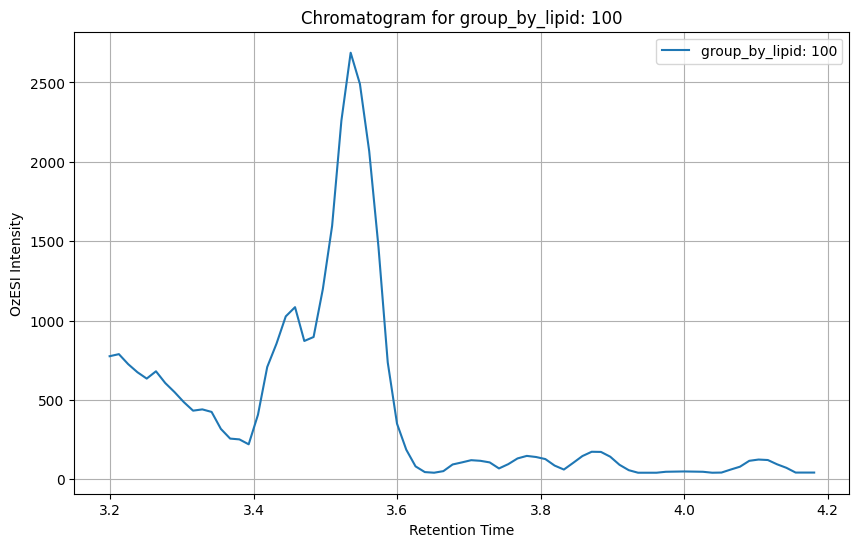

In [14]:
import matplotlib.pyplot as plt

# Function to plot the chromatogram for a specific group_by_lipid value
def plot_chromatogram(df, group_value):
    group_data = df[df['group_by_lipid'] == group_value]
    
    # Ensure the Retention_Time is sorted
    group_data = group_data.sort_values(by='Retention_Time')
    
    plt.figure(figsize=(10, 6))
    plt.plot(group_data['Retention_Time'], group_data['OzESI_Intensity'], label=f'group_by_lipid: {group_value}')
    plt.xlabel('Retention Time')
    plt.ylabel('OzESI Intensity')
    plt.title(f'Chromatogram for group_by_lipid: {group_value}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the specific group_by_lipid value you are interested in
specific_group_by_lipid_value = 100  # Replace with the actual value you are interested in

# Call the function to plot the chromatogram
plot_chromatogram(df_grouped, specific_group_by_lipid_value)


In [15]:
df_grouped.to_csv('OzON_Grouped_06jul24_v2_RT05.csv', index=False)
df_grouped

Lipid  Parent_Ion  Product_Ion  Retention_Time  \
979787    FA(10:1)_<>_n-2        325.2        183.0        3.537000   
1516181   FA(10:1)_<>_n-2        325.2        183.0        3.537000   
2256899   FA(10:1)_<>_n-2        325.2        183.0        3.537000   
2588978   FA(10:1)_<>_n-2        325.2        183.0        3.537000   
2921073   FA(10:1)_<>_n-2        325.2        183.0        3.537000   
...                    ...         ...          ...             ...   
8927492    FA(9:1)_<>_n-7        241.1        183.0        4.197533   
9216989    FA(9:1)_<>_n-7        241.1        183.0        4.197533   
9463902    FA(9:1)_<>_n-7        241.1        183.0        4.197533   
9753399    FA(9:1)_<>_n-7        241.1        183.0        4.197533   
11251811   FA(9:1)_<>_n-7        241.1        183.0        4.197533   

          OzESI_Intensity                                          Sample_ID  \
979787              216.0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
1516181             216.0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
2256899             216.0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
2588978             216.0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
2921073             216.0  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
...                   ...                                                ...   
8927492              41.0  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
9216989              41.0  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
9463902              41.0  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
9753399              41.0  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
11251811             41.0  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   

              Transition               Sample Species Class  \
979787    325.2 -> 183.0   WT_m1_cereb_FAD245    10:1    FA   
1516181   325.2 -> 183.0   WT_m1_cereb_FAD245    10:1    FA   
2256899   325.2 -> 183.0   WT_m1_cereb_FAD245    10:1    FA   
2588978   325.2 -> 183.0   WT_m1_cereb_FAD245    10:1    FA   
2921073   325.2 -> 183.0   WT_m1_cereb_FAD245    10:1    FA   
...                  ...                  ...     ...   ...   
8927492   241.1 -> 183.0  WT_m1_cortex_FAD245     9:1    FA   
9216989   241.1 -> 183.0  WT_m1_cortex_FAD245     9:1    FA   
9463902   241.1 -> 183.0  WT_m1_cortex_FAD245     9:1    FA   
9753399   241.1 -> 183.0  WT_m1_cortex_FAD245     9:1    FA   
11251811  241.1 -> 183.0  WT_m1_cortex_FAD245     9:1    FA   

                                            Possible_Lipids Biology Genotype  \
979787    FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...   cereb       WT   
1516181   FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...   cereb       WT   
2256899   FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...   cereb       WT   
2588978   FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...   cereb       WT   
2921073   FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...   cereb       WT   
...                                                     ...     ...      ...   
8927492   FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...  cortex       WT   
9216989   FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...  cortex       WT   
9463902   FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...  cortex       WT   
9753399   FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...  cortex       WT   
11251811  FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...  cortex       WT   

            Cage Mouse  group_by_ion  group_by_lipid  
979787    FAD245    m1            16               0  
1516181   FAD245    m1            16               0  
2256899   FAD245    m1            16               0  
2588978   FAD245    m1            16               0  
2921073   FAD245    m1            16               0  
...          ...   ...           ...             ...  
8927492   FAD245    m1             1             879  
9216989   FAD245    m1             1             

7562164    3.199233
8456189    3.199233
7562165    3.212150
8456190    3.212150
7562166    3.225083
             ...   
8456263    4.155333
7562239    4.168250
8456264    4.168250
7562240    4.181183
8456265    4.181183
Name: Retention_Time, Length: 154, dtype: float64


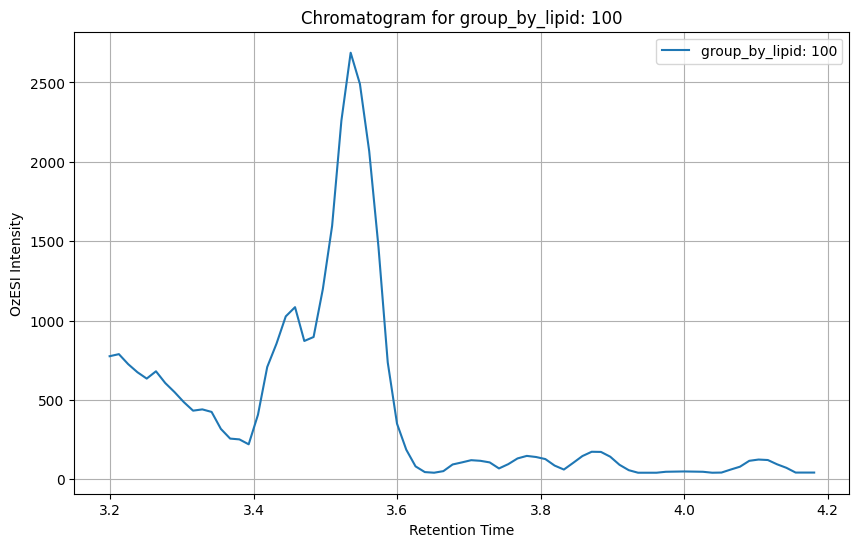

In [40]:
test = df_grouped[df_grouped['group_by_lipid'] == 100]['Retention_Time']
test.to_csv('test.csv', index=False)
import matplotlib.pyplot as plt

# Define the specific group_by_lipid value you are interested in
specific_group_by_lipid_value = 100  # Replace with the actual value you are interested in

# Print the Retention_Time values for the specific group_by_lipid value
print(df_grouped[df_grouped['group_by_lipid'] == specific_group_by_lipid_value]['Retention_Time'])

# Plot the chromatogram for the specific group_by_lipid value
def plot_chromatogram(df, group_value):
    group_data = df[df['group_by_lipid'] == group_value]
    plt.figure(figsize=(10, 6))
    plt.plot(group_data['Retention_Time'], group_data['OzESI_Intensity'], label=f'group_by_lipid: {group_value}')
    plt.xlabel('Retention Time')
    plt.ylabel('OzESI Intensity')
    plt.title(f'Chromatogram for group_by_lipid: {group_value}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the chromatogram
plot_chromatogram(df_grouped, specific_group_by_lipid_value)


# Lipid analysis after grouping

In [16]:
import os
import pandas as pd
from tqdm import tqdm
from scipy.signal import find_peaks, peak_widths
import re

class LipidAnalysis:
    def __init__(self, data):
        self.data = data
        self.height = 1000
        self.width = None
        self.rel_height = 0.5

    # Function to extract the carbon number and double bond count
    @staticmethod
    def extract_species_info(species):
        parts = species.split(':')
        carbon_number = float(parts[0].replace('d2-', '').replace('inf', '0')) if parts[0].isdigit() else float('inf')
        double_bond = float(parts[1]) if len(parts) > 1 and parts[1].isdigit() else float('inf')
        return carbon_number, double_bond

    @staticmethod
    def extract_lipid_info(lipid):
        match = re.match(r'FA\((\d+):(\d+)\)', lipid)
        if match:
            return int(match.group(1)), int(match.group(2))
        else:
            return float('inf'), float('inf')  # Return a large number to push unknown formats to the end

    @staticmethod
    def create_folder(directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def set_parameters(self, height=1000, width=None, rel_height=0.5):
        self.height = height
        self.width = width
        self.rel_height = rel_height

    def find_lipid_peaks(self, data=None, file_path=None, peak_analysis_csv=None, user_input="OFF", max_peaks=False):
        if user_input not in ["ON", "OFF"]:
            raise ValueError("user_input must be 'ON' or 'OFF'")
        
        if data is None and file_path is None:
            raise ValueError("Either data (DataFrame) or file_path (CSV file path) must be provided")
        
        if data is not None:
            self.data = data
        else:
            self.data = pd.read_csv(file_path)

        peak_data = []

        for filter_col in ['group_by_lipid']:
            unique_groups = self.data[filter_col].unique()

            for group in tqdm(unique_groups, desc=f"Processing {filter_col} groups"):
                group_data = self.data[self.data[filter_col] == group]
                peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=self.height, width=self.width)
                results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=self.rel_height)

                # Calculate sampling interval
                retention_times = group_data['Retention_Time'].values
                if len(retention_times) > 1:
                    sampling_interval = retention_times[1] - retention_times[0]
                else:
                    sampling_interval = 1  # Fallback value in case there's only one retention time

                for i, peak in enumerate(peaks):
                    metadata = group_data.iloc[peak][['Parent_Ion', 'Product_Ion', 'Sample', 'Species', 'group_by_lipid', 'group_by_ion', 'Biology', 'Genotype', 'Cage', 'Mouse', 'Lipid']]
                    left_ip = results_half[2][i]
                    right_ip = results_half[3][i]
                    left_time = group_data['Retention_Time'].iloc[int(left_ip)]
                    right_time = group_data['Retention_Time'].iloc[int(right_ip)]
                    width_in_time = right_time - left_time

                    fwhm = results_half[0][i] * sampling_interval

                    peak_data.append({
                        'Lipid': metadata['Lipid'],
                        'Retention_Time': group_data.iloc[peak]['Retention_Time'],
                        'OzESI_Intensity': group_data.iloc[peak]['OzESI_Intensity'],
                        'group_by_ion': metadata['group_by_ion'],
                        'group_by_lipid': metadata['group_by_lipid'],
                        'Sample_ID': group_data.iloc[peak]['Sample_ID'],
                        'Transition': group_data.iloc[peak]['Transition'],
                        'Sample': metadata['Sample'],
                        'Parent_Ion': metadata['Parent_Ion'],
                        'Product_Ion': metadata['Product_Ion'],
                        'Species': metadata['Species'],
                        'Class': group_data.iloc[peak]['Class'],
                        'Possible_Lipids': group_data.iloc[peak]['Possible_Lipids'],
                        'Biology': metadata['Biology'],
                        'Genotype': metadata['Genotype'],
                        'Cage': metadata['Cage'],
                        'Mouse': metadata['Mouse'],
                        'Peak_Height': properties['peak_heights'][i],
                        'FWHM': fwhm,
                        'Peak_Width': width_in_time,
                        'Peak_Area': properties['peak_heights'][i] * width_in_time,
                        'Filter_Column': filter_col  # Track which column was used for filtering
                    })

        peaks_df = pd.DataFrame(peak_data)

        # Ensure the directory for the CSV file exists
        csv_data_folder = os.path.dirname(peak_analysis_csv)
        self.create_folder(csv_data_folder)

        # Apply sorting
        peaks_df['species_sort'] = peaks_df['Species'].apply(self.extract_species_info)
        peaks_df = peaks_df.sort_values(by=['species_sort', 'Parent_Ion','Sample'], ascending=[True, False,True]).drop(columns='species_sort')

        # Save the DataFrame to the CSV file
        peaks_df.to_csv(peak_analysis_csv, index=False)
        
        if max_peaks:
            # Create second DataFrame and CSV for max values
            max_peaks_df = self.create_max_peaks_df(peaks_df)
            max_csv_filename = self.add_suffix_to_filename(peak_analysis_csv, '_max')
            max_peaks_df.to_csv(max_csv_filename, index=False)
            return max_peaks_df
        else:
            return peaks_df

    def create_max_peaks_df(self, peaks_df):
        # Sort by highest OzESI_Intensity first
        sorted_df = peaks_df.sort_values(by='OzESI_Intensity', ascending=False)
        
        # Filter by group_by_lipid and Sample for only the highest OzESI_Intensity value for each group_by_lipid and Sample
        max_peaks_df = sorted_df.groupby(['group_by_lipid', 'Sample']).first().reset_index()
        
        # Apply the same sorting as peaks_df
        max_peaks_df['species_sort'] = max_peaks_df['Species'].apply(self.extract_species_info)
        max_peaks_df = max_peaks_df.sort_values(by=['species_sort', 'Parent_Ion', 'Sample'], ascending=[True, False, True]).drop(columns='species_sort')

        # Ensure Lipid column is the first column
        columns = ['Lipid'] + [col for col in max_peaks_df.columns if col != 'Lipid']
        max_peaks_df = max_peaks_df[columns]

        return max_peaks_df

    @staticmethod
    def add_suffix_to_filename(filename, suffix):
        base, ext = os.path.splitext(filename)
        return f"{base}{suffix}{ext}"




    def plot_peaks(self, peaks_df, project_results=None, file_name_to_save=None):
        unique_lipids = peaks_df['Lipid'].unique()

        for lipid in unique_lipids:
            lipid_data = peaks_df[peaks_df['Lipid'] == lipid]
            plt.figure(figsize=(10, 6))

            plt.plot(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], label=lipid)
            plt.scatter(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], color='red')

            for _, row in lipid_data.iterrows():
                plt.annotate(f"Peak Height: {row['Peak_Height']:.2f}\nFWHM: {row['FWHM']:.2f}\nArea: {row['Peak_Area']:.2f}",
                             (row['Retention_Time'], row['OzESI_Intensity']),
                             textcoords="offset points",
                             xytext=(0, 10),
                             ha='center')

            plt.title(f"Peaks for Lipid: {lipid}")
            plt.xlabel('Retention Time')
            plt.ylabel('OzESI Intensity')
            plt.legend()
            plt.grid(True)

            plot_folder = f'{project_results}plots/'
            self.create_folder(plot_folder)
            plt.savefig(f"{plot_folder}{file_name_to_save}_{lipid}_peaks.png")
            plt.close()

    def plot_data_and_peaks(self, group_type, group_value, height=1000, width=None, rel_height=0.5):
        if group_type not in ['group_by_ion', 'group_by_lipid']:
            raise ValueError(f"group_type must be 'group_by_ion' or 'group_by_lipid'")

        if group_type not in self.data.columns:
            raise ValueError(f"group_type '{group_type}' is not a valid column in the data")

        group_data = self.data[self.data[group_type] == group_value]
        peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=height, width=width)
        results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=rel_height)

        plt.figure(figsize=(10, 6))
        plt.plot(group_data['Retention_Time'], group_data['OzESI_Intensity'], label='Intensity')
        plt.scatter(group_data['Retention_Time'].iloc[peaks], group_data['OzESI_Intensity'].iloc[peaks], color='red')

        # Annotate peaks
        for i, peak in enumerate(peaks):
            left_ip = results_half[2][i]
            right_ip = results_half[3][i]
            left_time = group_data['Retention_Time'].iloc[int(left_ip)]
            right_time = group_data['Retention_Time'].iloc[int(right_ip)]
            width_in_time = right_time - left_time

            fwhm = results_half[0][i] * (group_data['Retention_Time'].values[1] - group_data['Retention_Time'].values[0])

            plt.annotate(f"Peak Height: {properties['peak_heights'][i]:.2f}\nFWHM: {fwhm:.2f}\nArea: {properties['peak_heights'][i] * width_in_time:.2f}",
                        (group_data['Retention_Time'].iloc[peak], group_data['OzESI_Intensity'].iloc[peak]),
                        textcoords="offset points",
                        xytext=(0, 10),
                        ha='center')

        if group_type == 'group_by_lipid':
            lipid_value = group_data['Lipid'].iloc[0] if 'Lipid' in group_data.columns else 'Unknown'
            plot_title = f"Lipid: {lipid_value}"
        else:  # group_type == 'group_by_ion'
            parent_ion_value = group_data['Parent_Ion'].iloc[0] if 'Parent_Ion' in group_data.columns else 'Unknown'
            plot_title = f"Parent Ion: {parent_ion_value}"

        plt.title(f"Peaks for {plot_title}")
        plt.xlabel('Retention Time')
        plt.ylabel('OzESI Intensity')
        plt.legend()
        plt.grid(True)
        plt.show()


# Example usage:
# Initialize your LipidAnalysis class with some data
analysis = LipidAnalysis(df_grouped)



In [17]:
# Set parameters before calling the find_lipid_peaks method
analysis.set_parameters(height=300, width=None, rel_height=0.5)

peak_analysis_csv = f"{csv_data_folder}{project_data_name}_PeakAnalysis_07jul24{mode}.csv"  # Path to the PeakAnalysis output CSV file

# Call the find_lipid_peaks method
peaks_df = analysis.find_lipid_peaks(data=df_grouped, peak_analysis_csv=peak_analysis_csv, user_input=mode, max_peaks=True)


Processing group_by_lipid groups:   0%|          | 0/880 [00:00<?, ?it/s]

Processing group_by_lipid groups: 100%|██████████| 880/880 [00:03<00:00, 247.33it/s]


In [18]:
peaks_df
#print type of peaks_df


Lipid  group_by_lipid               Sample  \
446        FA(8:1)_<>_n-2              858   WT_m1_cereb_FAD245   
447        FA(8:1)_<>_n-2              859  WT_m1_cortex_FAD245   
448        FA(9:1)_<>_n-2              868   WT_m1_cereb_FAD245   
449        FA(9:1)_<>_n-2              869  WT_m1_cortex_FAD245   
450        FA(9:1)_<>_n-3              870   WT_m1_cereb_FAD245   
..                     ...             ...                  ...   
434  FA(22:6)_<FFFFF>_n-10             831  WT_m1_cortex_FAD245   
428  FA(22:6)_<BFFFF>_n-10             811  WT_m1_cortex_FAD245   
435  FA(22:6)_<FFFFF>_n-11             832   WT_m1_cereb_FAD245   
436  FA(22:6)_<FFFFF>_n-13             837  WT_m1_cortex_FAD245   
437  FA(22:6)_<FFFFF>_n-16             843  WT_m1_cortex_FAD245   

     Retention_Time  OzESI_Intensity  group_by_ion  \
446        3.344000          10529.0             8   
447        3.343983          12221.0             9   
448        3.602000          50798.0            12   
449        3.601983          61497.0            13   
450        3.344000          10529.0             8   
..              ...              ...           ...   
434        5.718483            572.0            37   
428        5.938333            303.0            35   
435        5.667433            345.0            30   
436        6.056050            428.0            21   
437        6.186467           1205.0             9   

                                             Sample_ID      Transition  \
446  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  297.2 -> 183.0   
447  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  297.2 -> 183.0   
448  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  311.3 -> 183.0   
449  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  311.3 -> 183.0   
450  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  297.2 -> 183.0   
..                                                 ...             ...   
434  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  381.3 -> 183.0   
428  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  379.3 -> 183.0   
435  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...  367.3 -> 183.0   
436  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  339.3 -> 183.0   
437  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...  297.2 -> 183.0   

     Parent_Ion  Product_Ion  ...  \
446       297.2        183.0  ...   
447       297.2        183.0  ...   
448       311.3        183.0  ...   
449       311.3        183.0  ...   
450       297.2        183.0  ...   
..          ...          ...  ...   
434       381.3        183.0  ...   
428       379.3        183.0  ...   
435       367.3        183.0  ...   
436       339.3        183.0  ...   
437       297.2        183.0  ...   

                                       Possible_Lipids Biology Genotype  \
446  FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...   cereb       WT   
447  FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...  cortex       WT   
448  FA(8:0) | FA(9:1)_<>_n-2 | FA(10:1)_<>_n-3 | F...   cereb       WT   
449  FA(8:0) | FA(9:1)_<>_n-2 | FA(10:1)_<>_n-3 | F...  cortex       WT   
450  FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...   cereb       WT   
..                                                 ...     ...      ...   
434  FA(13:0) | FA(14:1)_<>_n-2 | FA(15:1)_<>_n-3 |...  cortex       WT   
428  FA(15:2)_<B>_n-3 | FA(15:3)_<BF>_n-3 | FA(16:2...  cortex       WT   
435  FA(12:0) | FA(13:1)_<>_n-2 | FA(14:1)_<>_n-3 |...   cereb       WT   
436  FA(10:0) | FA(12:1)_<>_n-3 | FA(13:1)_<>_n-4 |...  cortex       WT   
437  FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...  cortex       WT   

       Cage Mouse Peak_Height FWHM  Peak_Width    Peak_Area   Filter_Column  
446  FAD245    m1     10529.0  0.0    0.064617   680.348883  group_by_lipid  
447  FAD245    m1     12221.0  0.0    0.064600   789.476600  group_by_lipid  
448  FAD245    m1     50798.0  0.0    0.064600  3281.550800  group_by_lipid  
449  FAD245    m1   

In [97]:
# Sorting the DataFrame by Peak_Area in ascending order and selecting the top 10 rows
min_10_peak_area_rows = peaks_df.nsmallest(10, 'Peak_Area')

# Printing the DataFrame with the top 10 minimum Peak_Area values
min_10_peak_area_rows


Lipid  Retention_Time  OzESI_Intensity  group_by_ion  \
356        FA(16:1)_<>_n-7         7.348100            501.0            20   
629       FA(18:2)_<F>_n-9         7.348100            501.0            20   
1113   FA(20:4)_<FFF>_n-11         7.348100            501.0            20   
101        FA(14:1)_<>_n-8         5.475850            506.0             9   
374      FA(16:2)_<F>_n-10         5.475850            506.0             9   
768    FA(18:4)_<FFF>_n-12         5.475850            506.0             9   
1215  FA(20:5)_<FFFF>_n-14         5.475850            506.0             9   
1214   FA(20:5)_<BFFF>_n-7         6.377017            508.0            41   
527        FA(18:1)_<>_n-9         9.144033            510.0            20   
869      FA(20:2)_<F>_n-11         9.144033            510.0            20   

      group_by_lipid                                          Sample_ID  \
356              194  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
629              344  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
1113             650  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
101               71  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
374              215  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
768              437  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
1215             727  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
1214             713  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
527              296  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
869              514  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   

          Transition               Sample  Parent_Ion  Product_Ion  ...  \
356   339.3 -> 183.0   WT_m1_cereb_FAD245       339.3        183.0  ...   
629   339.3 -> 183.0   WT_m1_cereb_FAD245       339.3        183.0  ...   
1113  339.3 -> 183.0   WT_m1_cereb_FAD245       339.3        183.0  ...   
101   297.2 -> 183.0  WT_m1_cortex_FAD245       297.2        183.0  ...   
374   297.2 -> 183.0  WT_m1_cortex_FAD245       297.2        183.0  ...   
768   297.2 -> 183.0  WT_m1_cortex_FAD245       297.2        183.0  ...   
1215  297.2 -> 183.0  WT_m1_cortex_FAD245       297.2        183.0  ...   
1214  393.4 -> 183.0  WT_m1_cortex_FAD245       393.4        183.0  ...   
527   339.3 -> 183.0   WT_m1_cereb_FAD245       339.3        183.0  ...   
869   339.3 -> 183.0   WT_m1_cereb_FAD245       339.3        183.0  ...   

                                        Possible_Lipids Biology Genotype  \
356   FA(10:0) | FA(12:1)_<>_n-3 | FA(13:1)_<>_n-4 |...   cereb       WT   
629   FA(10:0) | FA(12:1)_<>_n-3 | FA(13:1)_<>_n-4 |...   cereb       WT   
1113  FA(10:0) | FA(12:1)_<>_n-3 | FA(13:1)_<>_n-4 |...   cereb       WT   
101   FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...  cortex       WT   
374   FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...  cortex       WT   
768   FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...  cortex       WT   
1215  FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...  cortex       WT   
1214  FA(15:2)_<B>_n-2 | FA(15:3)_<BF>_n-2 | FA(16:2...  cortex       WT   
527   FA(10:0) | FA(12:1)_<>_n-3 | FA(13:1)_<>_n-4 |...   cereb       WT   
869   FA(10:0) | FA(12:1)_<>_n-3 | FA(13:1)_<>_n-4 |...   cereb       WT   

        Cage Mouse Peak_Height FWHM  Peak_Width  Peak_Area   Filter_Column  
356   FAD245    m1       501.0  0.0    0.012917   6.471250  group_by_lipid  
629   FAD245    m1       501.0  0.0    0.012917   6.471250  group_by_lipid  
1113  FAD245    m1       501.0  0.0    0.012917   6.471250  group_by_lipid  
101   FAD245    m1       506.0  0.0    0.012917   6.535833  group_by_lipid  
374   FAD245    m1       506.0  0.0    0.012917   6.535833  group_by_lipid  
768   FAD245    m1       506.0  0.0    0.012917   6.535833  group_by_lipid  
1215  FAD245    m1       506.0  0.0    0.012917   6.535833  group_by_lipid  
1214  FAD245    m1       508.0  0.0    0.012917   6.561667

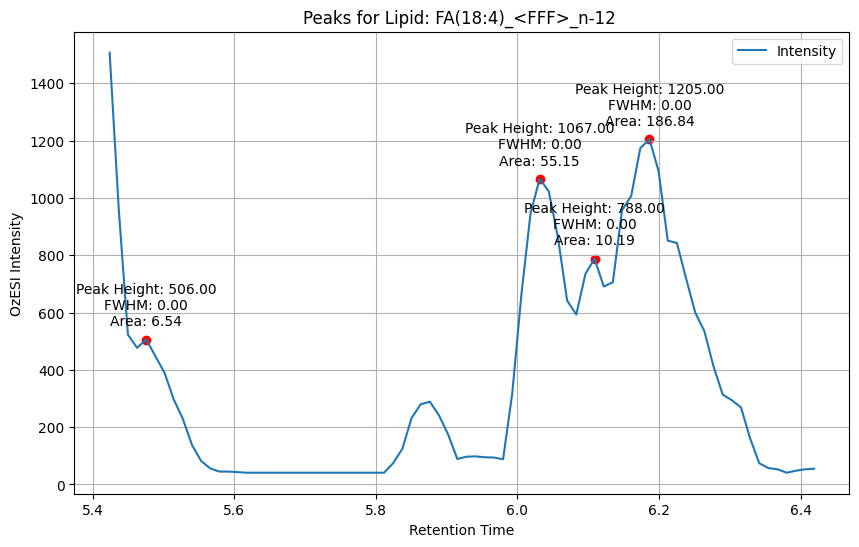

In [28]:

analysis.plot_data_and_peaks(group_type='group_by_lipid', group_value=437, height=500, width=2, rel_height=0.5)

Unique group_by_lipid values: [ 56  54  52  72  70  68  66  64  62  60  58  57  55  53  73  71  69  67
  65  63  61  59  80  78  76  74  96  94  92  90  88  86  84  82  81  79
  77  75  97  95  93  91  89  87  85  83 182 180 178 176 174 198 196 194
 192 190 188 186 184 183 181 179 177 175 199 197 195 193 191 189 187 185
 250 248 246 244 242 240 266 264 262 260 258 256 254 252 251 249 247 245
 243 241 267 265 263 261 259 257 255 253 280 278 276 274 272 270 268 296
 294 292 290 288 286 284 282 281 279 277 275 273 271 269 297 295 293 291
 289 287 285 283 328 326 324 322 320 300 318 298 316 314 344 342 312 340
 310 338 308 336 306 334 304 332 302 330 329 327 325 323 321 301 319 299
 317 315 345 343 313 341 311 339 309 337 307 335 305 333 303 331 734 732
 730 728 726 704 724 702 722 700 720 688 718 698 716 744 696 714 742 686
 712 740 684 694 710 738 692 708 736 680 706 678 682 690 735 733 731 729
 727 705 725 703 723 701 721 689 719 699 717 745 697 715 743 687 713 741
 685 695 711 739 693 

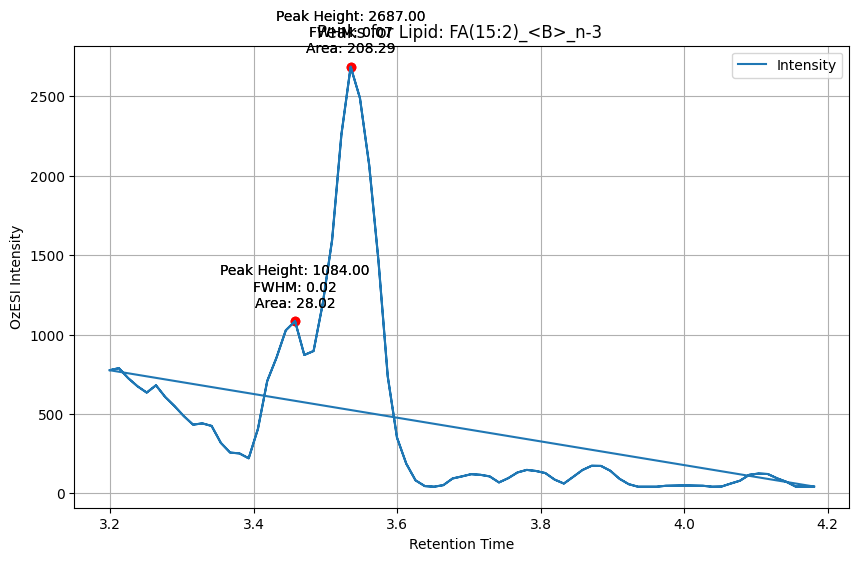

In [28]:
# Assuming you have already run the grouping and peak finding process as shown previously

# Initialize the LipidAnalysis class with the grouped DataFrame (already done previously)
lipid_analysis = LipidAnalysis(data=df_grouped)

# Plot data and peaks for a specific group
# Replace 'group_value' with the actual value you want to view
# For example, if you want to view peaks for a specific 'group_by_lipid' value

# You can get unique group values to decide which one to plot
unique_group_values = df_grouped['group_by_lipid'].unique()
print("Unique group_by_lipid values:", unique_group_values)

# Select one value to plot, for example the first one
group_value = 100

# Plot the peaks for the selected group value
lipid_analysis.plot_data_and_peaks(
    group_type='group_by_lipid',  # Could be 'group_by_ion' or 'group_by_lipid'
    group_value=group_value,      # The specific group value to plot
    height=1000,                  # Minimum height of peaks
    width=None,                   # Minimum width of peaks (can be None)
    rel_height=0.5                # Relative height for peak width calculation
)


In [43]:
# print(OzON_results['Lipid'].dtypes)
# print(OzON_results['Species'].dtypes)
# print(OzON_results['Lipid'].unique())
# OzON_results

# remove lipids that are not possible based on the species

In [39]:
# import pandas as pd
# import numpy as np
# import re

# def extract_matching_lipids(OzON_results_df):
#     # Make a copy of the original DataFrame
#     df_copy = OzON_results_df.copy()
    
#     # Rename the original 'Lipid' column to 'Possible_Lipids'
#     df_copy.rename(columns={'Lipid': 'Possible_Lipids'}, inplace=True)
    
#     # Function to find matching lipids for a given species and lipid string
#     def find_matches(lipid_string, species):
#         species_pattern = rf'FA\({species}\)_[^|]+'
#         matches = re.findall(species_pattern, lipid_string)
#         return matches if matches else [None]

#     # Apply the function to the DataFrame to get matching lipids
#     df_copy['Matches'] = df_copy.apply(
#         lambda row: find_matches(row['Possible_Lipids'], row['Species']),
#         axis=1
#     )

#     # Explode the matches into separate rows
#     exploded_df = df_copy.explode('Matches')

#     # Filter out rows where there was no match
#     matching_results_df = exploded_df[exploded_df['Matches'].notnull()].copy()

#     # Rename the Matches column to Lipid
#     matching_results_df.rename(columns={'Matches': 'Lipid'}, inplace=True)

#     # Move the Lipid column to be the first column
#     first_column = matching_results_df.pop('Lipid')
#     matching_results_df.insert(0, 'Lipid', first_column)

#     return matching_results_df

# # Sample usage
# # Assuming OzON_results_df is already defined and loaded with the appropriate data
# # df = pd.DataFrame({
# #     'Possible_Lipids': [...],
# #     'Parent_Ion': [...],
# #     'Product_Ion': [...],
# #     'Retention_Time': [...],
# #     'OzESI_Intensity': [...],
# #     'Sample_ID': [...],
# #     'Transition': [...],
# #     'Sample': [...],
# #     'Species': [...],
# #     'Class': [...],
# # })

# # Process the DataFrame
# matching_results_df = extract_matching_lipids(OzON_results_df)
# matching_results_df


# LIPID GROUPER and extrat matching lipids addedi nto class run a 1

In [33]:
import pandas as pd
from scipy.signal import find_peaks, peak_widths
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

class LipidAnalysis:
    def __init__(self, data):
        self.data = data

    @staticmethod
    def create_folder(directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def find_lipid_peaks(self, data=None, file_path=None, use_match_group=True, height=1000, width=None, rel_height=0.5, peak_analysis_csv=None, user_input="OFF"):
        if user_input not in ["ON", "OFF"]:
            raise ValueError("user_input must be 'ON' or 'OFF'")
        
        if data is None and file_path is None:
            raise ValueError("Either data (DataFrame) or file_path (CSV file path) must be provided")
        
        if data is not None:
            self.data = data
        else:
            self.data = pd.read_csv(file_path)

        filter_col = 'group_by_ion' if use_match_group else 'group_by_lipid'
        unique_groups = self.data[filter_col].unique()
        peak_data = []

        for group in tqdm(unique_groups, desc="Processing groups"):
            group_data = self.data[self.data[filter_col] == group]
            peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=height, width=width)
            results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=rel_height)

            # Calculate sampling interval
            retention_times = group_data['Retention_Time'].values
            if len(retention_times) > 1:
                sampling_interval = retention_times[1] - retention_times[0]
            else:
                sampling_interval = 1  # Fallback value in case there's only one retention time

            print(f"Sampling Interval: {sampling_interval}")

            for i, peak in enumerate(peaks):
                metadata = group_data.iloc[peak][['Parent_Ion', 'Product_Ion', 'Sample','Species', 'group_by_lipid', 'group_by_ion', 'Biology', 'Genotype', 'Cage', 'Mouse', 'Lipid']]
                left_ip = results_half[2][i]
                right_ip = results_half[3][i]
                left_time = group_data['Retention_Time'].iloc[int(left_ip)]
                right_time = group_data['Retention_Time'].iloc[int(right_ip)]
                width_in_time = right_time - left_time

                fwhm = results_half[0][i] * sampling_interval

                print(f"group_by_lipid: {metadata['group_by_lipid']} - Peak {i}: Start Time = {left_time}, End Time = {right_time}, Width = {width_in_time}, FWHM = {fwhm}")

                peak_data.append({
                    'Lipid': metadata['Lipid'],
                    'Retention_Time': group_data.iloc[peak]['Retention_Time'],
                    'OzESI_Intensity': group_data.iloc[peak]['OzESI_Intensity'],
                    'group_by_ion': metadata['group_by_ion'],
                    'group_by_lipid': metadata['group_by_lipid'],
                    'Sample_ID': group_data.iloc[peak]['Sample_ID'],
                    'Transition': group_data.iloc[peak]['Transition'],
                    'Sample': metadata['Sample'],
                    'Parent_Ion': metadata['Parent_Ion'],
                    'Product_Ion': metadata['Product_Ion'],
                    'Species': metadata['Species'],
                    'Class': group_data.iloc[peak]['Class'],
                    'Possible_Lipids': group_data.iloc[peak]['Possible_Lipids'],
                    'Biology': metadata['Biology'],
                    'Genotype': metadata['Genotype'],
                    'Cage': metadata['Cage'],
                    'Mouse': metadata['Mouse'],
                    'Peak_Height': properties['peak_heights'][i],
                    'FWHM': fwhm,
                    'Peak_Width': width_in_time,
                    'Peak_Area': properties['peak_heights'][i] * width_in_time
                })

        peaks_df = pd.DataFrame(peak_data)

        # Ensure the directory for the CSV file exists
        csv_data_folder = os.path.dirname(peak_analysis_csv)
        self.create_folder(csv_data_folder)

        # Save the DataFrame to the CSV file
        peaks_df.to_csv(peak_analysis_csv, index=False)
        return peaks_df

    def plot_peaks(self, peaks_df, project_results=None, file_name_to_save=None):
        unique_lipids = peaks_df['Lipid'].unique()

        for lipid in unique_lipids:
            lipid_data = peaks_df[peaks_df['Lipid'] == lipid]
            plt.figure(figsize=(10, 6))

            plt.plot(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], label=lipid)
            plt.scatter(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], color='red')

            for _, row in lipid_data.iterrows():
                plt.annotate(f"Peak Height: {row['Peak_Height']:.2f}\nFWHM: {row['FWHM']:.2f}\nArea: {row['Peak_Area']:.2f}",
                             (row['Retention_Time'], row['OzESI_Intensity']),
                             textcoords="offset points",
                             xytext=(0,10),
                             ha='center')

            plt.title(f"Peaks for Lipid: {lipid}")
            plt.xlabel('Retention Time')
            plt.ylabel('OzESI Intensity')
            plt.legend()
            plt.grid(True)

            plot_folder = f'{project_results}plots/'
            self.create_folder(plot_folder)
            plt.savefig(f"{plot_folder}{file_name_to_save}_{lipid}_peaks.png")
            plt.close()

    def plot_data_and_peaks(self, group_type, group_value, height=1000, width=None, rel_height=0.5):
        if group_type not in ['group_by_ion', 'group_by_lipid']:
            raise ValueError(f"group_type must be 'group_by_ion' or 'group_by_lipid'")

        if group_type not in self.data.columns:
            raise ValueError(f"group_type '{group_type}' is not a valid column in the data")

        group_data = self.data[self.data[group_type] == group_value]
        peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=height, width=width)
        results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=rel_height)

        plt.figure(figsize=(10, 6))
        plt.plot(group_data['Retention_Time'], group_data['OzESI_Intensity'], label='Intensity')
        plt.scatter(group_data['Retention_Time'].iloc[peaks], group_data['OzESI_Intensity'].iloc[peaks], color='red')

        # Annotate peaks
        for i, peak in enumerate(peaks):
            left_ip = results_half[2][i]
            right_ip = results_half[3][i]
            left_time = group_data['Retention_Time'].iloc[int(left_ip)]
            right_time = group_data['Retention_Time'].iloc[int(right_ip)]
            width_in_time = right_time - left_time

            fwhm = results_half[0][i] * (group_data['Retention_Time'].values[1] - group_data['Retention_Time'].values[0])

            plt.annotate(f"Peak Height: {properties['peak_heights'][i]:.2f}\nFWHM: {fwhm:.2f}\nArea: {properties['peak_heights'][i] * width_in_time:.2f}",
                        (group_data['Retention_Time'].iloc[peak], group_data['OzESI_Intensity'].iloc[peak]),
                        textcoords="offset points",
                        xytext=(0, 10),
                        ha='center')

        if group_type == 'group_by_lipid':
            lipid_value = group_data['Lipid'].iloc[0] if 'Lipid' in group_data.columns else 'Unknown'
            plot_title = f"Lipid: {lipid_value}"
        else:  # group_type == 'group_by_ion'
            parent_ion_value = group_data['Parent_Ion'].iloc[0] if 'Parent_Ion' in group_data.columns else 'Unknown'
            plot_title = f"Parent Ion: {parent_ion_value}"

        plt.title(f"Peaks for {plot_title}")
        plt.xlabel('Retention Time')
        plt.ylabel('OzESI Intensity')
        plt.legend()
        plt.grid(True)
        plt.show()

class LipidGrouper:
    def __init__(self, new_columns=None):
        self.new_columns = new_columns

    def extract_values_from_sample(self, sample):
        """
        Helper function to extract values from the Sample column based on the new_columns dictionary.

        :param sample: The sample string from which to extract values.
        :return: Dictionary with extracted values for each column.
        """
        extracted_values = {}
        for col, values in self.new_columns.items():
            extracted_values[col] = next((value for value in values if value in sample), '')
        return extracted_values

    def create_columns_from_sample(self, df):
        """
        Creates new columns in the DataFrame based on the Sample column values using a provided dictionary.

        :param df: Input DataFrame containing the Sample column.
        :return: DataFrame with new columns added.
        """
        if not self.new_columns:
            return df

        # Create a copy of the original DataFrame
        df_copy = df.copy()

        # Extract new column values using apply and the helper function
        extracted_df = df_copy['Sample'].apply(self.extract_values_from_sample)

        # Convert the series of dictionaries to a DataFrame
        extracted_df = pd.DataFrame(extracted_df.tolist(), index=df_copy.index)

        # Ensure there are no duplicate columns
        for col in self.new_columns.keys():
            if col in df_copy.columns:
                df_copy.drop(columns=[col], inplace=True)

        # Concatenate the original DataFrame with the new columns
        df_copy = pd.concat([df_copy, extracted_df], axis=1)
        return df_copy

    def group_by_ion(self, df):
        df['group_by_ion'] = df.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()
        return df

    def group_by_lipid(self, df, group_columns=None):
        if group_columns is None:
            group_columns = ['Lipid', 'Biology', 'Genotype', 'Mouse', 'Cage']

        df['group_by_lipid'] = df.groupby(group_columns).ngroup()
        return df

    def group_by_func(self, df, group_columns=None):
        df = self.create_columns_from_sample(df)
        df = self.group_by_ion(df)
        df = self.group_by_lipid(df, group_columns)
        return df

    def save_grouped_results(self, df, file_path):
        """
        Saves the DataFrame to a CSV file in the specified location.

        :param df: DataFrame to be saved.
        :param file_path: Path where the CSV file will be saved.
        """
        df.to_csv(file_path, index=False)
        print(f"File successfully saved to: {file_path}")

    def create_folder(self, folder_path):
        """
        Creates the folder if it does not exist already.

        :param folder_path: Path of the folder to be created.
        """
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder created: {folder_path}")
        else:
            print(f"Folder already exists: {folder_path}")

    def extract_matching_lipids(self, OzON_results_df):
        # Make a copy of the original DataFrame
        df_copy = OzON_results_df.copy()
        
        # Rename the original 'Lipid' column to 'Possible_Lipids'
        df_copy.rename(columns={'Lipid': 'Possible_Lipids'}, inplace=True)
        
        # Function to find matching lipids and their corresponding class for a given species and lipid string
        def find_matches(lipid_string, class_string, species):
            species_pattern = rf'FA\({species}\)_[^|]+'
            lipid_matches = re.findall(species_pattern, lipid_string)
            
            if lipid_matches:
                lipid_list = [lipid.strip() for lipid in lipid_string.split(' | ')]
                class_list = [cls.strip() for cls in class_string.split(' | ')]
                matched_lipids_classes = [(lipid, class_list[lipid_list.index(lipid.strip())]) for lipid in lipid_matches]
                return matched_lipids_classes
            return [(None, None)]

        # Apply the function to the DataFrame to get matching lipids and their classes
        df_copy['Matches'] = df_copy.apply(
            lambda row: find_matches(row['Possible_Lipids'], row['Class'], row['Species']),
            axis=1
        )

        # Explode the matches into separate rows
        exploded_df = df_copy.explode('Matches')

        # Split the Matches column into Lipid and Class
        exploded_df[['Lipid', 'Class']] = pd.DataFrame(exploded_df['Matches'].tolist(), index=exploded_df.index)

        # Filter out rows where there was no match
        matching_results_df = exploded_df[exploded_df['Lipid'].notnull()].copy()

        # Drop the Matches column as it is no longer needed
        matching_results_df.drop(columns=['Matches'], inplace=True)

        # Move the Lipid column to be the first column
        first_column = matching_results_df.pop('Lipid')
        matching_results_df.insert(0, 'Lipid', first_column)

        # Move the Possible_Lipids column to be the last column
        possible_lipids_column = matching_results_df.pop('Possible_Lipids')
        matching_results_df['Possible_Lipids'] = possible_lipids_column

        return matching_results_df


# Extract matching lipids and group by functions
grouper = LipidGrouper(new_columns={
    'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
    'Genotype': ['5xFAD', 'WT'],
    'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
    'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
})


peak_analysis_csv = f"{csv_data_folder}{project_data_name}_PeakAnalysis_{mode}.csv"  # Path to the PeakAnalysis output CSV file
grouped_data_csv = f"{csv_data_folder}{project_data_name}_GroupedData_{mode}.csv"  # Path to the GroupedData output CSV file


# Extract matching lipids
matching_results_df = grouper.extract_matching_lipids(OzON_results)

# Group the DataFrame
df_grouped = grouper.group_by_func(matching_results_df)

# Create the folder if it doesn't exist
grouper.create_folder(csv_data_folder)

# Save the grouped DataFrame to a CSV file
grouper.save_grouped_results(df_grouped, grouped_data_csv)


# View the final grouped DataFrame and peaks DataFrame
df_grouped


: 

# handle nan values make causing the erro?

In [20]:
import pandas as pd
from scipy.signal import find_peaks, peak_widths
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

class LipidAnalysis:
    def __init__(self, data):
        self.data = data

    @staticmethod
    def create_folder(directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def find_lipid_peaks(self, data=None, file_path=None, use_match_group=True, height=1000, width=None, rel_height=0.5, peak_analysis_csv=None, user_input="OFF"):
        if user_input not in ["ON", "OFF"]:
            raise ValueError("user_input must be 'ON' or 'OFF'")
        
        if data is None and file_path is None:
            raise ValueError("Either data (DataFrame) or file_path (CSV file path) must be provided")
        
        if data is not None:
            self.data = data
        else:
            self.data = pd.read_csv(file_path)

        filter_col = 'group_by_ion' if use_match_group else 'group_by_lipid'
        unique_groups = self.data[filter_col].unique()
        peak_data = []

        for group in tqdm(unique_groups, desc="Processing groups"):
            group_data = self.data[self.data[filter_col] == group]
            peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=height, width=width)
            results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=rel_height)

            # Calculate sampling interval
            retention_times = group_data['Retention_Time'].values
            if len(retention_times) > 1:
                sampling_interval = retention_times[1] - retention_times[0]
            else:
                sampling_interval = 1  # Fallback value in case there's only one retention time

            print(f"Sampling Interval: {sampling_interval}")

            for i, peak in enumerate(peaks):
                metadata = group_data.iloc[peak][['Parent_Ion', 'Product_Ion', 'Sample','Species', 'group_by_lipid', 'group_by_ion', 'Biology', 'Genotype', 'Cage', 'Mouse', 'Lipid']]
                left_ip = results_half[2][i]
                right_ip = results_half[3][i]
                left_time = group_data['Retention_Time'].iloc[int(left_ip)]
                right_time = group_data['Retention_Time'].iloc[int(right_ip)]
                width_in_time = right_time - left_time

                fwhm = results_half[0][i] * sampling_interval

                print(f"group_by_lipid: {metadata['group_by_lipid']} - Peak {i}: Start Time = {left_time}, End Time = {right_time}, Width = {width_in_time}, FWHM = {fwhm}")

                peak_data.append({
                    'Lipid': metadata['Lipid'] if pd.notna(metadata['Lipid']) else 'Unknown',
                    'Retention_Time': group_data.iloc[peak]['Retention_Time'],
                    'OzESI_Intensity': group_data.iloc[peak]['OzESI_Intensity'],
                    'group_by_ion': metadata['group_by_ion'],
                    'group_by_lipid': metadata['group_by_lipid'],
                    'Sample_ID': group_data.iloc[peak]['Sample_ID'],
                    'Transition': group_data.iloc[peak]['Transition'],
                    'Sample': metadata['Sample'],
                    'Parent_Ion': metadata['Parent_Ion'],
                    'Product_Ion': metadata['Product_Ion'],
                    'Species': metadata['Species'],
                    'Class': group_data.iloc[peak]['Class'],
                    'Possible_Lipids': group_data.iloc[peak]['Possible_Lipids'],
                    'Biology': metadata['Biology'],
                    'Genotype': metadata['Genotype'],
                    'Cage': metadata['Cage'],
                    'Mouse': metadata['Mouse'],
                    'Peak_Height': properties['peak_heights'][i],
                    'FWHM': fwhm,
                    'Peak_Width': width_in_time,
                    'Peak_Area': properties['peak_heights'][i] * width_in_time
                })

        peaks_df = pd.DataFrame(peak_data)

        # Ensure the directory for the CSV file exists
        csv_data_folder = os.path.dirname(peak_analysis_csv)
        self.create_folder(csv_data_folder)

        # Save the DataFrame to the CSV file
        peaks_df.to_csv(peak_analysis_csv, index=False)
        return peaks_df

    def plot_peaks(self, peaks_df, project_results=None, file_name_to_save=None):
        unique_lipids = peaks_df['Lipid'].unique()

        for lipid in unique_lipids:
            lipid_data = peaks_df[peaks_df['Lipid'] == lipid]
            plt.figure(figsize=(10, 6))

            plt.plot(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], label=lipid)
            plt.scatter(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], color='red')

            for _, row in lipid_data.iterrows():
                plt.annotate(f"Peak Height: {row['Peak_Height']:.2f}\nFWHM: {row['FWHM']:.2f}\nArea: {row['Peak_Area']:.2f}",
                             (row['Retention_Time'], row['OzESI_Intensity']),
                             textcoords="offset points",
                             xytext=(0,10),
                             ha='center')

            plt.title(f"Peaks for Lipid: {lipid}")
            plt.xlabel('Retention Time')
            plt.ylabel('OzESI Intensity')
            plt.legend()
            plt.grid(True)

            plot_folder = f'{project_results}plots/'
            self.create_folder(plot_folder)
            plt.savefig(f"{plot_folder}{file_name_to_save}_{lipid}_peaks.png")
            plt.close()

    def plot_data_and_peaks(self, group_type, group_value, height=1000, width=None, rel_height=0.5):
        if group_type not in ['group_by_ion', 'group_by_lipid']:
            raise ValueError(f"group_type must be 'group_by_ion' or 'group_by_lipid'")

        if group_type not in self.data.columns:
            raise ValueError(f"group_type '{group_type}' is not a valid column in the data")

        group_data = self.data[self.data[group_type] == group_value]
        peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=height, width=width)
        results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=rel_height)

        plt.figure(figsize=(10, 6))
        plt.plot(group_data['Retention_Time'], group_data['OzESI_Intensity'], label='Intensity')
        plt.scatter(group_data['Retention_Time'].iloc[peaks], group_data['OzESI_Intensity'].iloc[peaks], color='red')

        # Annotate peaks
        for i, peak in enumerate(peaks):
            left_ip = results_half[2][i]
            right_ip = results_half[3][i]
            left_time = group_data['Retention_Time'].iloc[int(left_ip)]
            right_time = group_data['Retention_Time'].iloc[int(right_ip)]
            width_in_time = right_time - left_time

            fwhm = results_half[0][i] * (group_data['Retention_Time'].values[1] - group_data['Retention_Time'].values[0])

            plt.annotate(f"Peak Height: {properties['peak_heights'][i]:.2f}\nFWHM: {fwhm:.2f}\nArea: {properties['peak_heights'][i] * width_in_time:.2f}",
                        (group_data['Retention_Time'].iloc[peak], group_data['OzESI_Intensity'].iloc[peak]),
                        textcoords="offset points",
                        xytext=(0, 10),
                        ha='center')

        if group_type == 'group_by_lipid':
            lipid_value = group_data['Lipid'].iloc[0] if 'Lipid' in group_data.columns and pd.notna(group_data['Lipid'].iloc[0]) else 'Unknown'
            plot_title = f"Lipid: {lipid_value}"
        else:  # group_type == 'group_by_ion'
            parent_ion_value = group_data['Parent_Ion'].iloc[0] if 'Parent_Ion' in group_data.columns else 'Unknown'
            plot_title = f"Parent Ion: {parent_ion_value}"

        plt.title(f"Peaks for {plot_title}")
        plt.xlabel('Retention Time')
        plt.ylabel('OzESI Intensity')
        plt.legend()
        plt.grid(True)
        plt.show()

class LipidGrouper:
    def __init__(self, new_columns=None):
        self.new_columns = new_columns

    def extract_values_from_sample(self, sample):
        """
        Helper function to extract values from the Sample column based on the new_columns dictionary.

        :param sample: The sample string from which to extract values.
        :return: Dictionary with extracted values for each column.
        """
        extracted_values = {}
        for col, values in self.new_columns.items():
            extracted_values[col] = next((value for value in values if value in sample), '')
        return extracted_values

    def create_columns_from_sample(self, df):
        """
        Creates new columns in the DataFrame based on the Sample column values using a provided dictionary.

        :param df: Input DataFrame containing the Sample column.
        :return: DataFrame with new columns added.
        """
        if not self.new_columns:
            return df

        # Create a copy of the original DataFrame
        df_copy = df.copy()

        # Extract new column values using apply and the helper function
        extracted_df = df_copy['Sample'].apply(self.extract_values_from_sample)

        # Convert the series of dictionaries to a DataFrame
        extracted_df = pd.DataFrame(extracted_df.tolist(), index=df_copy.index)

        # Ensure there are no duplicate columns
        for col in self.new_columns.keys():
            if col in df_copy.columns:
                df_copy.drop(columns=[col], inplace=True)

        # Concatenate the original DataFrame with the new columns
        df_copy = pd.concat([df_copy, extracted_df], axis=1)
        return df_copy

    def group_by_ion(self, df):
        df['group_by_ion'] = df.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()
        return df

    def group_by_lipid(self, df, group_columns=None):
        if group_columns is None:
            group_columns = ['Lipid', 'Biology', 'Genotype', 'Mouse', 'Cage']

        df['group_by_lipid'] = df.groupby(group_columns).ngroup()
        return df

    def group_by_func(self, df, group_columns=None):
        df = self.create_columns_from_sample(df)
        df = self.group_by_ion(df)
        df = self.group_by_lipid(df, group_columns)
        return df

    def save_grouped_results(self, df, file_path):
        """
        Saves the DataFrame to a CSV file in the specified location.

        :param df: DataFrame to be saved.
        :param file_path: Path where the CSV file will be saved.
        """
        df.to_csv(file_path, index=False)
        print(f"File successfully saved to: {file_path}")

    def create_folder(self, folder_path):
        """
        Creates the folder if it does not exist already.

        :param folder_path: Path of the folder to be created.
        """
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder created: {folder_path}")
        else:
            print(f"Folder already exists: {folder_path}")

    def extract_matching_lipids(self, OzON_results_df):
        # Make a copy of the original DataFrame
        df_copy = OzON_results_df.copy()
        
        # Rename the original 'Lipid' column to 'Possible_Lipids'
        df_copy.rename(columns={'Lipid': 'Possible_Lipids'}, inplace=True)
        
        # Function to find matching lipids and their corresponding class for a given species and lipid string
        def find_matches(lipid_string, class_string, species):
            species_pattern = rf'FA\({species}\)_[^|]+'
            lipid_matches = re.findall(species_pattern, lipid_string)
            
            if lipid_matches:
                lipid_list = [lipid.strip() for lipid in lipid_string.split(' | ')]
                class_list = [cls.strip() for cls in class_string.split(' | ')]
                matched_lipids_classes = [(lipid, class_list[lipid_list.index(lipid.strip())]) for lipid in lipid_matches]
                return matched_lipids_classes
            return [(None, None)]

        # Apply the function to the DataFrame to get matching lipids and their classes
        df_copy['Matches'] = df_copy.apply(
            lambda row: find_matches(row['Possible_Lipids'], row['Class'], row['Species']),
            axis=1
        )

        # Explode the matches into separate rows
        exploded_df = df_copy.explode('Matches')

        # Split the Matches column into Lipid and Class
        exploded_df[['Lipid', 'Class']] = pd.DataFrame(exploded_df['Matches'].tolist(), index=exploded_df.index)

        # Filter out rows where there was no match
        matching_results_df = exploded_df[exploded_df['Lipid'].notnull()].copy()

        # Drop the Matches column as it is no longer needed
        matching_results_df.drop(columns=['Matches'], inplace=True)

        # Move the Lipid column to be the first column
        first_column = matching_results_df.pop('Lipid')
        matching_results_df.insert(0, 'Lipid', first_column)

        # Move the Possible_Lipids column to be the last column
        possible_lipids_column = matching_results_df.pop('Possible_Lipids')
        matching_results_df['Possible_Lipids'] = possible_lipids_column

        return matching_results_df


# Extract matching lipids and group by functions
grouper = LipidGrouper(new_columns={
    'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
    'Genotype': ['5xFAD', 'WT'],
    'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
    'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
})

# # Ensure you have defined 'csv_data_folder', 'project_data_name', 'mode', and 'OzON_results'
# peak_analysis_csv = f"{csv_data_folder}{project_data_name}_PeakAnalysis_{mode}.csv"  # Path to the PeakAnalysis output CSV file
# grouped_data_csv = f"{csv_data_folder}{project_data_name}_GroupedData_{mode}.csv"  # Path to the GroupedData output CSV file

# # Extract matching lipids
# matching_results_df = grouper.extract_matching_lipids(OzON_results)

# # Group the DataFrame
# df_grouped = grouper.group_by_func(matching_results_df)

# # Create the folder if it doesn't exist
# grouper.create_folder(csv_data_folder)

# # Save the grouped DataFrame to a CSV file
# grouper.save_grouped_results(df_grouped, grouped_data_csv)

# # View the final grouped DataFrame and peaks DataFrame
# df_grouped


In [21]:
# Assuming you have the df_grouped DataFrame already

# Initialize the LipidAnalysis class with the grouped DataFrame
lipid_analysis = LipidAnalysis(data=df_grouped)

# Call the find_lipid_peaks method
# Adjust the parameters as needed
peaks_df = lipid_analysis.find_lipid_peaks(
    data=df_grouped,            # The grouped DataFrame
    use_match_group=True,       # Whether to use the 'group_by_ion' or 'group_by_lipid'
    height=1000,                # Minimum height of peaks
    width=None,                 # Minimum width of peaks (can be None)
    rel_height=0.5,             # Relative height for peak width calculation
    peak_analysis_csv='path/to/save/peaks.csv',  # Path to save the peaks analysis CSV
    user_input="ON"            # User input state, can be "ON" or "OFF"
)

# Now peaks_df contains the peaks information
print(peaks_df)


Processing groups:   0%|          | 0/86 [00:00<?, ?it/s]

Sampling Interval: 0.012916666666666465
Sampling Interval: 0.012916666666666465
Sampling Interval: 0.012933333333332797
Sampling Interval: 0.012933333333333685
group_by_lipid: 48 - Peak 0: Start Time = 6.561383333333334, End Time = 3.098716666666667, Width = -3.462666666666667, FWHM = 0.04997320686263034
group_by_lipid: 48 - Peak 1: Start Time = 4.791283333333333, End Time = 3.098716666666667, Width = -1.6925666666666666, FWHM = 0.04995405435733667
group_by_lipid: 152 - Peak 2: Start Time = 3.0212000000000003, End Time = 3.098716666666667, Width = 0.07751666666666646, FWHM = 0.07358095603904985
group_by_lipid: 860 - Peak 3: Start Time = 6.561383333333334, End Time = 3.098716666666667, Width = -3.462666666666667, FWHM = 0.026235687887144848
group_by_lipid: 860 - Peak 4: Start Time = 6.561383333333334, End Time = 3.098716666666667, Width = -3.462666666666667, FWHM = 0.026235687887144848
group_by_lipid: 48 - Peak 5: Start Time = 4.791283333333333, End Time = 3.098716666666667, Width = -1.

Processing groups:   6%|▌         | 5/86 [00:00<00:04, 19.84it/s]

group_by_lipid: 46 - Peak 132: Start Time = 3.3052333333333337, End Time = 3.36985, Width = 0.06461666666666632, FWHM = 0.06531348069624578
group_by_lipid: 174 - Peak 133: Start Time = 7.039233333333334, End Time = 7.116750000000001, Width = 0.0775166666666669, FWHM = 0.08586545336188028
group_by_lipid: 320 - Peak 134: Start Time = 7.039233333333334, End Time = 7.116750000000001, Width = 0.0775166666666669, FWHM = 0.08586545336188028
group_by_lipid: 858 - Peak 135: Start Time = 3.3052333333333337, End Time = 3.36985, Width = 0.06461666666666632, FWHM = 0.06531348069624578
group_by_lipid: 870 - Peak 136: Start Time = 3.3052333333333337, End Time = 3.36985, Width = 0.06461666666666632, FWHM = 0.06531348069624578
group_by_lipid: 174 - Peak 137: Start Time = 7.039233333333334, End Time = 7.116750000000001, Width = 0.0775166666666669, FWHM = 0.08586545336188028
group_by_lipid: 320 - Peak 138: Start Time = 7.039233333333334, End Time = 7.116750000000001, Width = 0.0775166666666669, FWHM = 0.

Processing groups:   8%|▊         | 7/86 [00:00<00:13,  6.05it/s]

group_by_lipid: 128 - Peak 426: Start Time = 3.7954, End Time = 3.847083333333333, Width = 0.05168333333333308, FWHM = 0.05953118301674808
group_by_lipid: 128 - Peak 427: Start Time = 3.9892, End Time = 4.002133333333333, Width = 0.012933333333333241, FWHM = 0.007534722222206441
group_by_lipid: 268 - Peak 428: Start Time = 8.6793, End Time = 8.795583333333333, Width = 0.11628333333333352, FWHM = 0.11977171379528767
group_by_lipid: 268 - Peak 429: Start Time = 8.7439, End Time = 8.756816666666667, Width = 0.012916666666667354, FWHM = 0.006682971014485294
group_by_lipid: 268 - Peak 430: Start Time = 8.976466666666667, End Time = 9.066916666666668, Width = 0.09045000000000059, FWHM = 0.09666095519919965
group_by_lipid: 374 - Peak 431: Start Time = 8.00745, End Time = 3.6920333333333337, Width = -4.315416666666667, FWHM = 0.06441079909155077
group_by_lipid: 374 - Peak 432: Start Time = 3.679116666666667, End Time = 3.6920333333333337, Width = 0.01291666666666691, FWHM = 0.00720930232560313

Processing groups:   9%|▉         | 8/86 [00:01<00:24,  3.20it/s]

group_by_lipid: 40 - Peak 703: Start Time = 3.795, End Time = 3.807916666666667, Width = 0.01291666666666691, FWHM = 0.013058413926491015
group_by_lipid: 40 - Peak 704: Start Time = 3.872516666666667, End Time = 3.911283333333333, Width = 0.03876666666666617, FWHM = 0.036386673593082154
group_by_lipid: 40 - Peak 705: Start Time = 4.014633333333333, End Time = 4.040483333333333, Width = 0.02585000000000015, FWHM = 0.02778302687790883
group_by_lipid: 194 - Peak 706: Start Time = 6.908816666666667, End Time = 6.9863333333333335, Width = 0.0775166666666669, FWHM = 0.0766483557472167
group_by_lipid: 194 - Peak 707: Start Time = 7.2189, End Time = 7.296416666666667, Width = 0.07751666666666779, FWHM = 0.0800892286924439
group_by_lipid: 194 - Peak 708: Start Time = 7.464383333333334, End Time = 7.5419, Width = 0.07751666666666601, FWHM = 0.0823487208240911
group_by_lipid: 194 - Peak 709: Start Time = 7.554833333333334, End Time = 7.56775, Width = 0.012916666666666465, FWHM = 0.006614342948714

Processing groups:  10%|█         | 9/86 [00:02<00:26,  2.95it/s]

group_by_lipid: 294 - Peak 229: Start Time = 8.885216666666667, End Time = 9.0015, Width = 0.11628333333333352, FWHM = 0.12015288663620256
group_by_lipid: 398 - Peak 230: Start Time = 4.014233333333333, End Time = 4.040066666666667, Width = 0.02583333333333382, FWHM = 0.032627526213422645
group_by_lipid: 398 - Peak 231: Start Time = 4.053, End Time = 4.065916666666667, Width = 0.012916666666667354, FWHM = 0.007534722222206441
group_by_lipid: 398 - Peak 232: Start Time = 4.233883333333334, End Time = 4.272633333333333, Width = 0.038749999999999396, FWHM = 0.02821648625196714
group_by_lipid: 398 - Peak 233: Start Time = 4.298483333333333, End Time = 4.376, Width = 0.0775166666666669, FWHM = 0.07682373028430631
group_by_lipid: 294 - Peak 234: Start Time = 8.885216666666667, End Time = 9.0015, Width = 0.11628333333333352, FWHM = 0.12015288663620256
group_by_lipid: 398 - Peak 235: Start Time = 4.014233333333333, End Time = 4.040066666666667, Width = 0.02583333333333382, FWHM = 0.03262752621

Processing groups:  12%|█▏        | 10/86 [00:02<00:24,  3.04it/s]

group_by_lipid: 36 - Peak 214: Start Time = 3.3159333333333336, End Time = 3.5097333333333336, Width = 0.19379999999999997, FWHM = 0.18438716760358617
group_by_lipid: 60 - Peak 215: Start Time = 4.039466666666667, End Time = 4.9439, Width = 0.9044333333333334, FWHM = 0.044738046954773895
group_by_lipid: 122 - Peak 216: Start Time = 3.354683333333333, End Time = 3.3805333333333336, Width = 0.025850000000000595, FWHM = 0.025796062335343376
group_by_lipid: 122 - Peak 217: Start Time = 3.3159333333333336, End Time = 3.5097333333333336, Width = 0.19379999999999997, FWHM = 0.18440552216559672
group_by_lipid: 292 - Peak 218: Start Time = 8.845833333333333, End Time = 8.936283333333334, Width = 0.09045000000000059, FWHM = 0.0943852411513869
group_by_lipid: 396 - Peak 219: Start Time = 4.310783333333333, End Time = 4.323716666666667, Width = 0.012933333333333685, FWHM = 0.01201740506328084
group_by_lipid: 396 - Peak 220: Start Time = 4.272033333333334, End Time = 4.375383333333334, Width = 0.10

Processing groups:  13%|█▎        | 11/86 [00:02<00:26,  2.87it/s]

group_by_lipid: 830 - Peak 332: Start Time = 6.390366666666667, End Time = 5.6151333333333335, Width = -0.7752333333333334, FWHM = 0.057664095252030784
group_by_lipid: 58 - Peak 333: Start Time = 5.0208, End Time = 5.033716666666667, Width = 0.012916666666666465, FWHM = 0.007221128608901572
group_by_lipid: 58 - Peak 334: Start Time = 5.059566666666667, End Time = 5.0854, Width = 0.02583333333333293, FWHM = 0.02249281609194557
group_by_lipid: 58 - Peak 335: Start Time = 5.188766666666667, End Time = 5.201683333333333, Width = 0.012916666666666465, FWHM = 0.006976381461657378
group_by_lipid: 58 - Peak 336: Start Time = 5.162933333333333, End Time = 5.343816666666667, Width = 0.18088333333333395, FWHM = 0.1735537432283797
group_by_lipid: 58 - Peak 337: Start Time = 5.447166666666667, End Time = 5.537616666666667, Width = 0.0904499999999997, FWHM = 0.0869528842343578
group_by_lipid: 394 - Peak 338: Start Time = 8.005416666666667, End Time = 3.702916666666667, Width = -4.3025, FWHM = 0.0703

Processing groups:  19%|█▊        | 16/86 [00:03<00:15,  4.39it/s]

group_by_lipid: 727 - Peak 715: Start Time = 11.00575, End Time = 5.424166666666667, Width = -5.581583333333334, FWHM = 0.03203778184037258
group_by_lipid: 727 - Peak 716: Start Time = 6.005583333333334, End Time = 6.057266666666667, Width = 0.05168333333333308, FWHM = 0.045913374922297745
group_by_lipid: 727 - Peak 717: Start Time = 6.0831, End Time = 6.23815, Width = 0.15505000000000013, FWHM = 0.16290121907920166
group_by_lipid: 843 - Peak 718: Start Time = 6.005583333333334, End Time = 6.057266666666667, Width = 0.05168333333333308, FWHM = 0.045913374922297745
group_by_lipid: 843 - Peak 719: Start Time = 6.0831, End Time = 6.23815, Width = 0.15505000000000013, FWHM = 0.16290121907920166
group_by_lipid: 71 - Peak 720: Start Time = 5.359566666666667, End Time = 5.424166666666667, Width = 0.06460000000000043, FWHM = 0.06430492772369743
group_by_lipid: 97 - Peak 721: Start Time = 6.005583333333334, End Time = 6.057266666666667, Width = 0.05168333333333308, FWHM = 0.045913374922297745
g

Processing groups:  20%|█▉        | 17/86 [00:03<00:15,  4.57it/s]

Sampling Interval: 0.012916666666667354
group_by_lipid: 197 - Peak 0: Start Time = 6.8445833333333335, End Time = 6.935033333333334, Width = 0.09045000000000059, FWHM = 0.08978930391190498
group_by_lipid: 269 - Peak 1: Start Time = 8.679283333333334, End Time = 8.7568, Width = 0.07751666666666601, FWHM = 0.07703931506384547
group_by_lipid: 269 - Peak 2: Start Time = 8.782633333333333, End Time = 8.795566666666668, Width = 0.012933333333334573, FWHM = 0.009711419753086589
group_by_lipid: 269 - Peak 3: Start Time = 8.963516666666667, End Time = 9.028133333333331, Width = 0.0646166666666641, FWHM = 0.0708173396017738
group_by_lipid: 197 - Peak 4: Start Time = 6.8445833333333335, End Time = 6.935033333333334, Width = 0.09045000000000059, FWHM = 0.08978930391190426
group_by_lipid: 269 - Peak 5: Start Time = 8.679283333333334, End Time = 8.7568, Width = 0.07751666666666601, FWHM = 0.07698384197811561
group_by_lipid: 269 - Peak 6: Start Time = 8.782633333333333, End Time = 8.795566666666668, 

Processing groups:  21%|██        | 18/86 [00:04<00:17,  3.96it/s]

group_by_lipid: 43 - Peak 217: Start Time = 3.7953833333333336, End Time = 3.847066666666666, Width = 0.05168333333333264, FWHM = 0.05947064535546373
group_by_lipid: 197 - Peak 218: Start Time = 6.8445833333333335, End Time = 6.935033333333334, Width = 0.09045000000000059, FWHM = 0.08978930391194831
group_by_lipid: 269 - Peak 219: Start Time = 8.679283333333334, End Time = 8.7568, Width = 0.07751666666666601, FWHM = 0.07698384197812735
group_by_lipid: 269 - Peak 220: Start Time = 8.782633333333333, End Time = 8.795566666666668, Width = 0.012933333333334573, FWHM = 0.009711419753086589
group_by_lipid: 269 - Peak 221: Start Time = 8.963516666666667, End Time = 9.028133333333331, Width = 0.0646166666666641, FWHM = 0.07081733960176353
group_by_lipid: 375 - Peak 222: Start Time = 8.007416666666668, End Time = 3.653266666666666, Width = -4.3541500000000015, FWHM = 0.029296683197429393
group_by_lipid: 375 - Peak 223: Start Time = 3.7953833333333336, End Time = 3.847066666666666, Width = 0.051

Processing groups:  22%|██▏       | 19/86 [00:05<00:23,  2.81it/s]

group_by_lipid: 401 - Peak 461: Start Time = 4.014616666666667, End Time = 4.066316666666667, Width = 0.0517000000000003, FWHM = 0.06056256852792463
group_by_lipid: 19 - Peak 462: Start Time = 3.8595833333333336, End Time = 3.9241833333333336, Width = 0.06459999999999999, FWHM = 0.05920671466304671
group_by_lipid: 19 - Peak 463: Start Time = 4.014616666666667, End Time = 4.066316666666667, Width = 0.0517000000000003, FWHM = 0.06056256852792463
group_by_lipid: 195 - Peak 464: Start Time = 6.818350000000001, End Time = 6.870016666666667, Width = 0.05166666666666675, FWHM = 0.04994089508195503
group_by_lipid: 195 - Peak 465: Start Time = 6.895866666666667, End Time = 6.9863, Width = 0.09043333333333337, FWHM = 0.08718057005148103
group_by_lipid: 195 - Peak 466: Start Time = 7.464366666666667, End Time = 7.5548, Width = 0.09043333333333337, FWHM = 0.08990020690496608
group_by_lipid: 265 - Peak 467: Start Time = 7.464366666666667, End Time = 7.5548, Width = 0.09043333333333337, FWHM = 0.089

Processing groups:  23%|██▎       | 20/86 [00:05<00:24,  2.69it/s]

group_by_lipid: 295 - Peak 303: Start Time = 8.600933333333334, End Time = 8.7043, Width = 0.10336666666666616, FWHM = 0.10062405517762418
group_by_lipid: 295 - Peak 304: Start Time = 8.872266666666667, End Time = 9.001466666666667, Width = 0.12920000000000087, FWHM = 0.12382608161132297
group_by_lipid: 399 - Peak 305: Start Time = 4.04005, End Time = 4.104666666666667, Width = 0.06461666666666677, FWHM = 0.060077702245637105
group_by_lipid: 399 - Peak 306: Start Time = 4.208033333333334, End Time = 4.2597000000000005, Width = 0.05166666666666675, FWHM = 0.053210996477333315
group_by_lipid: 399 - Peak 307: Start Time = 4.298466666666667, End Time = 4.363066666666667, Width = 0.06459999999999955, FWHM = 0.06866905074608333
group_by_lipid: 39 - Peak 308: Start Time = 3.1098000000000003, End Time = 3.1744000000000003, Width = 0.06459999999999999, FWHM = 0.05668950681079486
group_by_lipid: 39 - Peak 309: Start Time = 3.0968666666666667, End Time = 3.2906833333333334, Width = 0.193816666666

Processing groups:  24%|██▍       | 21/86 [00:05<00:22,  2.83it/s]

group_by_lipid: 293 - Peak 95: Start Time = 8.574483333333333, End Time = 8.690766666666667, Width = 0.11628333333333352, FWHM = 0.11072825898639883
group_by_lipid: 293 - Peak 96: Start Time = 8.845816666666668, End Time = 8.936266666666667, Width = 0.09044999999999881, FWHM = 0.09376901670841738
group_by_lipid: 397 - Peak 97: Start Time = 4.29785, End Time = 4.36245, Width = 0.06459999999999955, FWHM = 0.07059190422746758
group_by_lipid: 397 - Peak 98: Start Time = 4.47875, End Time = 4.620866666666667, Width = 0.14211666666666734, FWHM = 0.1477576511216354
group_by_lipid: 397 - Peak 99: Start Time = 4.607950000000001, End Time = 4.620866666666667, Width = 0.012916666666666465, FWHM = 0.013974873278979215
group_by_lipid: 609 - Peak 100: Start Time = 8.574483333333333, End Time = 8.690766666666667, Width = 0.11628333333333352, FWHM = 0.11072825898639883
group_by_lipid: 37 - Peak 101: Start Time = 3.3288333333333333, End Time = 3.380516666666667, Width = 0.051683333333333525, FWHM = 0.0

Processing groups:  26%|██▌       | 22/86 [00:06<00:25,  2.53it/s]

group_by_lipid: 59 - Peak 440: Start Time = 5.447166666666667, End Time = 5.524683333333334, Width = 0.0775166666666669, FWHM = 0.07658763661952084
group_by_lipid: 291 - Peak 441: Start Time = 8.8452, End Time = 8.922733333333333, Width = 0.07753333333333323, FWHM = 0.0751582852872368
group_by_lipid: 395 - Peak 442: Start Time = 8.005383333333334, End Time = 3.72875, Width = -4.276633333333335, FWHM = 0.09887366792581129
group_by_lipid: 395 - Peak 443: Start Time = 3.780433333333333, End Time = 3.845033333333333, Width = 0.06459999999999999, FWHM = 0.05843880368093937
group_by_lipid: 395 - Peak 444: Start Time = 3.85795, End Time = 3.8708666666666662, Width = 0.012916666666666021, FWHM = 0.009554794520550384
group_by_lipid: 395 - Peak 445: Start Time = 3.8837833333333336, End Time = 3.896716666666667, Width = 0.012933333333333241, FWHM = 0.007749999999981616
group_by_lipid: 743 - Peak 446: Start Time = 8.057066666666667, End Time = 5.4084, Width = -2.648666666666667, FWHM = 0.006576697

Processing groups:  27%|██▋       | 23/86 [00:08<00:48,  1.29it/s]

Sampling Interval: 0.012916666666666465
group_by_lipid: 83 - Peak 0: Start Time = 5.808316666666667, End Time = 5.847083333333334, Width = 0.038766666666666616, FWHM = 0.030525127601098854
group_by_lipid: 83 - Peak 1: Start Time = 5.769550000000001, End Time = 5.898750000000001, Width = 0.12919999999999998, FWHM = 0.13582201294528706
group_by_lipid: 83 - Peak 2: Start Time = 6.040883333333333, End Time = 6.0538, Width = 0.012916666666666465, FWHM = 0.007909324522760507
group_by_lipid: 83 - Peak 3: Start Time = 6.1184, End Time = 6.157166666666667, Width = 0.038766666666666616, FWHM = 0.04709472222158211
group_by_lipid: 83 - Peak 4: Start Time = 6.221766666666667, End Time = 6.312200000000001, Width = 0.09043333333333337, FWHM = 0.08716214394565663
group_by_lipid: 83 - Peak 5: Start Time = 6.6352166666666665, End Time = 6.648133333333334, Width = 0.012916666666667354, FWHM = 0.0067333231954580415
group_by_lipid: 187 - Peak 6: Start Time = 6.699816666666667, End Time = 6.5835333333333335

Processing groups:  28%|██▊       | 24/86 [00:10<01:07,  1.09s/it]

group_by_lipid: 741 - Peak 1933: Start Time = 5.808316666666667, End Time = 5.847083333333334, Width = 0.038766666666666616, FWHM = 0.030525127601103555
group_by_lipid: 741 - Peak 1934: Start Time = 5.769550000000001, End Time = 5.898750000000001, Width = 0.12919999999999998, FWHM = 0.1358220129452693
group_by_lipid: 741 - Peak 1935: Start Time = 6.040883333333333, End Time = 6.0538, Width = 0.012916666666666465, FWHM = 0.007909324522744583
group_by_lipid: 741 - Peak 1936: Start Time = 6.1184, End Time = 6.157166666666667, Width = 0.038766666666666616, FWHM = 0.047094722221587164
group_by_lipid: 741 - Peak 1937: Start Time = 6.221766666666667, End Time = 6.312200000000001, Width = 0.09043333333333337, FWHM = 0.08717954040646282
group_by_lipid: 857 - Peak 1938: Start Time = 5.808316666666667, End Time = 5.847083333333334, Width = 0.038766666666666616, FWHM = 0.030525127601103555
group_by_lipid: 857 - Peak 1939: Start Time = 5.769550000000001, End Time = 5.898750000000001, Width = 0.1291

Processing groups:  29%|██▉       | 25/86 [00:10<01:03,  1.04s/it]

group_by_lipid: 254 - Peak 836: Start Time = 7.616366666666667, End Time = 7.655133333333334, Width = 0.038766666666666616, FWHM = 0.036111940152929595
group_by_lipid: 334 - Peak 837: Start Time = 9.153883333333331, End Time = 7.0608, Width = -2.0930833333333307, FWHM = 0.050889877414586386
group_by_lipid: 334 - Peak 838: Start Time = 7.151233333333334, End Time = 7.2546, Width = 0.10336666666666616, FWHM = 0.09909324163697947
group_by_lipid: 334 - Peak 839: Start Time = 7.53885, End Time = 7.551766666666667, Width = 0.012916666666667354, FWHM = 0.01630569306931431
group_by_lipid: 334 - Peak 840: Start Time = 7.616366666666667, End Time = 7.655133333333334, Width = 0.038766666666666616, FWHM = 0.036111940152929595
group_by_lipid: 390 - Peak 841: Start Time = 3.882366666666667, End Time = 4.06325, Width = 0.18088333333333306, FWHM = 0.18398294464593384
group_by_lipid: 390 - Peak 842: Start Time = 3.972816666666666, End Time = 3.9857333333333336, Width = 0.012916666666667354, FWHM = 0.00

Processing groups:  30%|███       | 26/86 [00:11<01:00,  1.02s/it]

group_by_lipid: 391 - Peak 966: Start Time = 3.895283333333333, End Time = 4.06325, Width = 0.16796666666666704, FWHM = 0.1740988116979864
group_by_lipid: 391 - Peak 967: Start Time = 3.9986333333333337, End Time = 4.011550000000001, Width = 0.01291666666666691, FWHM = 0.007123477297888298
group_by_lipid: 391 - Peak 968: Start Time = 3.9986333333333337, End Time = 4.050316666666667, Width = 0.051683333333333525, FWHM = 0.043177607451808334
group_by_lipid: 391 - Peak 969: Start Time = 4.1278500000000005, End Time = 4.19245, Width = 0.06459999999999955, FWHM = 0.05598290664571387
group_by_lipid: 739 - Peak 970: Start Time = 5.833333333333334, End Time = 5.923783333333334, Width = 0.0904499999999997, FWHM = 0.09593454215702577
group_by_lipid: 739 - Peak 971: Start Time = 6.117583333333334, End Time = 6.375983333333334, Width = 0.25839999999999996, FWHM = 0.24885731570305997
group_by_lipid: 739 - Peak 972: Start Time = 6.22095, End Time = 6.2597000000000005, Width = 0.038750000000000284, F

Processing groups:  31%|███▏      | 27/86 [00:13<01:12,  1.24s/it]

group_by_lipid: 332 - Peak 1506: Start Time = 7.305666666666667, End Time = 7.370266666666667, Width = 0.06459999999999955, FWHM = 0.06472297297296993
group_by_lipid: 332 - Peak 1507: Start Time = 7.473633333333334, End Time = 7.5253, Width = 0.05166666666666586, FWHM = 0.051612174979987484
group_by_lipid: 332 - Peak 1508: Start Time = 7.602833333333334, End Time = 7.628666666666667, Width = 0.02583333333333293, FWHM = 0.03450109649124237
group_by_lipid: 332 - Peak 1509: Start Time = 7.693266666666667, End Time = 7.706183333333334, Width = 0.012916666666666465, FWHM = 0.01819248826289794
group_by_lipid: 332 - Peak 1510: Start Time = 7.951683333333333, End Time = 8.003366666666667, Width = 0.05168333333333308, FWHM = 0.05440516123757249
group_by_lipid: 388 - Peak 1511: Start Time = 4.075566666666667, End Time = 4.204766666666667, Width = 0.12919999999999998, FWHM = 0.13667514668132238
group_by_lipid: 388 - Peak 1512: Start Time = 4.153083333333334, End Time = 4.166, Width = 0.0129166666

Processing groups:  33%|███▎      | 28/86 [00:15<01:16,  1.32s/it]

group_by_lipid: 483 - Peak 1436: Start Time = 10.17395, End Time = 10.251466666666667, Width = 0.07751666666666779, FWHM = 0.0803050108932616
group_by_lipid: 483 - Peak 1437: Start Time = 10.2773, End Time = 10.290233333333331, Width = 0.01293333333333102, FWHM = 0.007163076923066984
group_by_lipid: 483 - Peak 1438: Start Time = 10.36775, End Time = 10.406516666666668, Width = 0.03876666666666928, FWHM = 0.03473847953217674
group_by_lipid: 483 - Peak 1439: Start Time = 10.3936, End Time = 10.406516666666668, Width = 0.01291666666666913, FWHM = 0.006520555555543186
group_by_lipid: 483 - Peak 1440: Start Time = 10.4582, End Time = 10.471116666666669, Width = 0.01291666666666913, FWHM = 0.006617054263570448
group_by_lipid: 483 - Peak 1441: Start Time = 10.4582, End Time = 10.509883333333336, Width = 0.051683333333336634, FWHM = 0.05549302325583078
group_by_lipid: 483 - Peak 1442: Start Time = 10.5228, End Time = 10.535716666666668, Width = 0.012916666666667354, FWHM = 0.011978030303026351

Processing groups:  34%|███▎      | 29/86 [00:16<01:06,  1.16s/it]

group_by_lipid: 282 - Peak 368: Start Time = 9.036166666666666, End Time = 9.15245, Width = 0.11628333333333352, FWHM = 0.11099659204699855
group_by_lipid: 330 - Peak 369: Start Time = 7.937933333333333, End Time = 8.002533333333334, Width = 0.06460000000000132, FWHM = 0.06998223583265364
group_by_lipid: 850 - Peak 370: Start Time = 5.612266666666667, End Time = 5.689783333333334, Width = 0.0775166666666669, FWHM = 0.0728729002226412
group_by_lipid: 850 - Peak 371: Start Time = 6.180766666666667, End Time = 6.245366666666667, Width = 0.06460000000000043, FWHM = 0.06619471312831338
group_by_lipid: 282 - Peak 372: Start Time = 8.467666666666666, End Time = 8.519350000000001, Width = 0.05168333333333486, FWHM = 0.06194147456278593
group_by_lipid: 282 - Peak 373: Start Time = 8.596866666666667, End Time = 8.609783333333334, Width = 0.012916666666667354, FWHM = 0.00954461651916644
group_by_lipid: 282 - Peak 374: Start Time = 8.777750000000001, End Time = 8.9328, Width = 0.15504999999999924,

Processing groups:  41%|████      | 35/86 [00:16<00:16,  3.00it/s]

group_by_lipid: 283 - Peak 411: Start Time = 8.454716666666666, End Time = 8.532250000000001, Width = 0.07753333333333501, FWHM = 0.07813295437087352
group_by_lipid: 283 - Peak 412: Start Time = 8.764816666666666, End Time = 8.91985, Width = 0.1550333333333338, FWHM = 0.15072001325305076
group_by_lipid: 283 - Peak 413: Start Time = 8.868166666666667, End Time = 8.894016666666667, Width = 0.02585000000000015, FWHM = 0.02532830246484065
group_by_lipid: 283 - Peak 414: Start Time = 9.0103, End Time = 9.126583333333334, Width = 0.11628333333333352, FWHM = 0.11418959508843653
group_by_lipid: 331 - Peak 415: Start Time = 7.912066666666667, End Time = 8.002516666666667, Width = 0.0904499999999997, FWHM = 0.09218267844073312
group_by_lipid: 667 - Peak 416: Start Time = 7.912066666666667, End Time = 8.0542, Width = 0.14213333333333278, FWHM = 0.14337464664075475
group_by_lipid: 667 - Peak 417: Start Time = 8.015433333333334, End Time = 8.0542, Width = 0.03876666666666573, FWHM = 0.0325158057573

Processing groups:  43%|████▎     | 37/86 [00:16<00:13,  3.71it/s]

group_by_lipid: 712 - Peak 28: Start Time = 8.056683333333334, End Time = 5.459683333333333, Width = -2.5970000000000004, FWHM = 0.06407970256546619
group_by_lipid: 140 - Peak 29: Start Time = 3.3149, End Time = 3.3924333333333334, Width = 0.07753333333333323, FWHM = 0.06623411802565453
group_by_lipid: 424 - Peak 30: Start Time = 4.6198500000000005, End Time = 5.4726, Width = 0.8527499999999995, FWHM = 0.061002041423722814
group_by_lipid: 712 - Peak 31: Start Time = 8.056683333333334, End Time = 5.459683333333333, Width = -2.5970000000000004, FWHM = 0.06407970256547793
group_by_lipid: 712 - Peak 32: Start Time = 4.6198500000000005, End Time = 5.459683333333333, Width = 0.839833333333333, FWHM = 0.0640024804520777
group_by_lipid: 712 - Peak 33: Start Time = 4.6198500000000005, End Time = 5.459683333333333, Width = 0.839833333333333, FWHM = 0.0640024804520777
group_by_lipid: 202 - Peak 34: Start Time = 6.557933333333334, End Time = 5.485533333333334, Width = -1.0724, FWHM = 0.03210948673

Processing groups:  45%|████▌     | 39/86 [00:17<00:13,  3.47it/s]

group_by_lipid: 304 - Peak 253: Start Time = 7.021616666666667, End Time = 7.112066666666667, Width = 0.09045000000000059, FWHM = 0.08767020193311639
group_by_lipid: 304 - Peak 254: Start Time = 7.29295, End Time = 7.305866666666667, Width = 0.012916666666666465, FWHM = 0.0072310969116088164
group_by_lipid: 304 - Peak 255: Start Time = 7.9648, End Time = 7.99065, Width = 0.025849999999999262, FWHM = 0.0219345543345651
group_by_lipid: 362 - Peak 256: Start Time = 8.003566666666668, End Time = 3.6494, Width = -4.354166666666668, FWHM = 0.03058613637155369
group_by_lipid: 362 - Peak 257: Start Time = 3.714, End Time = 3.7656833333333335, Width = 0.051683333333333525, FWHM = 0.05613395480225719
Sampling Interval: 0.012916666666666465
group_by_lipid: 302 - Peak 0: Start Time = 7.75725, End Time = 7.770183333333334, Width = 0.012933333333333685, FWHM = 0.020684523809523542
group_by_lipid: 302 - Peak 1: Start Time = 7.886466666666667, End Time = 7.989816666666667, Width = 0.10334999999999983,

Processing groups:  50%|█████     | 43/86 [00:17<00:07,  5.89it/s]

Sampling Interval: 0.012916666666666465
group_by_lipid: 151 - Peak 0: Start Time = 3.537583333333333, End Time = 3.602183333333333, Width = 0.06459999999999999, FWHM = 0.06427899052899103
group_by_lipid: 151 - Peak 1: Start Time = 3.537583333333333, End Time = 3.602183333333333, Width = 0.06459999999999999, FWHM = 0.06427899052898808
group_by_lipid: 151 - Peak 2: Start Time = 3.537583333333333, End Time = 3.602183333333333, Width = 0.06459999999999999, FWHM = 0.06427899052899395
group_by_lipid: 109 - Peak 3: Start Time = 3.537583333333333, End Time = 3.602183333333333, Width = 0.06459999999999999, FWHM = 0.06427899052897046
group_by_lipid: 109 - Peak 4: Start Time = 3.537583333333333, End Time = 3.602183333333333, Width = 0.06459999999999999, FWHM = 0.06427899052897046
Sampling Interval: 0.012933333333332797
group_by_lipid: 357 - Peak 0: Start Time = 3.653466666666666, End Time = 3.718066666666666, Width = 0.06459999999999999, FWHM = 0.06564404473590128
group_by_lipid: 357 - Peak 1: St

Processing groups:  52%|█████▏    | 45/86 [00:18<00:07,  5.22it/s]

group_by_lipid: 367 - Peak 80: Start Time = 3.650816666666667, End Time = 3.7283333333333335, Width = 0.07751666666666646, FWHM = 0.07998236263735994
group_by_lipid: 425 - Peak 81: Start Time = 4.6198500000000005, End Time = 5.446750000000001, Width = 0.8269000000000002, FWHM = 0.03696750700650595
group_by_lipid: 425 - Peak 82: Start Time = 5.575950000000001, End Time = 5.627633333333334, Width = 0.05168333333333308, FWHM = 0.0457015796909125
group_by_lipid: 713 - Peak 83: Start Time = 8.056650000000001, End Time = 5.433833333333333, Width = -2.622816666666668, FWHM = 0.0418762269369696
group_by_lipid: 713 - Peak 84: Start Time = 5.575950000000001, End Time = 5.627633333333334, Width = 0.05168333333333308, FWHM = 0.0457015796909125
group_by_lipid: 829 - Peak 85: Start Time = 6.3899333333333335, End Time = 5.653483333333334, Width = -0.7364499999999996, FWHM = 0.09534368837399577
group_by_lipid: 367 - Peak 86: Start Time = 3.650816666666667, End Time = 3.7283333333333335, Width = 0.0775

Processing groups:  55%|█████▍    | 47/86 [00:18<00:08,  4.58it/s]

group_by_lipid: 363 - Peak 150: Start Time = 7.900183333333334, End Time = 3.6493833333333336, Width = -4.2508, FWHM = 0.1271118996201607
group_by_lipid: 363 - Peak 151: Start Time = 3.7139833333333336, End Time = 3.7656666666666663, Width = 0.05168333333333264, FWHM = 0.04689788391490957
group_by_lipid: 363 - Peak 152: Start Time = 3.8948666666666663, End Time = 3.9594666666666662, Width = 0.06459999999999999, FWHM = 0.059932308201056814
group_by_lipid: 305 - Peak 153: Start Time = 7.0216, End Time = 7.099116666666667, Width = 0.0775166666666669, FWHM = 0.08240277670524188
group_by_lipid: 305 - Peak 154: Start Time = 7.9131, End Time = 7.964783333333334, Width = 0.05168333333333397, FWHM = 0.04536222946344429
group_by_lipid: 363 - Peak 155: Start Time = 7.900183333333334, End Time = 3.6493833333333336, Width = -4.2508, FWHM = 0.12711189962017244
group_by_lipid: 363 - Peak 156: Start Time = 3.7139833333333336, End Time = 3.7656666666666663, Width = 0.05168333333333264, FWHM = 0.0468978

Processing groups:  56%|█████▌    | 48/86 [00:19<00:08,  4.47it/s]

group_by_lipid: 303 - Peak 75: Start Time = 7.692633333333334, End Time = 7.808916666666667, Width = 0.11628333333333263, FWHM = 0.10693811147773567
group_by_lipid: 303 - Peak 76: Start Time = 7.873516666666667, End Time = 7.951033333333334, Width = 0.0775166666666669, FWHM = 0.0839931106108128
group_by_lipid: 361 - Peak 77: Start Time = 4.1395333333333335, End Time = 4.204133333333334, Width = 0.06460000000000043, FWHM = 0.06484530064019862
group_by_lipid: 637 - Peak 78: Start Time = 7.705550000000001, End Time = 7.718466666666667, Width = 0.012916666666666465, FWHM = 0.015996334876545136
group_by_lipid: 637 - Peak 79: Start Time = 7.692633333333334, End Time = 7.808916666666667, Width = 0.11628333333333263, FWHM = 0.10693811147773567
group_by_lipid: 637 - Peak 80: Start Time = 7.873516666666667, End Time = 7.951033333333334, Width = 0.0775166666666669, FWHM = 0.0839931106108128
group_by_lipid: 637 - Peak 81: Start Time = 8.028550000000001, End Time = 8.054400000000001, Width = 0.0258

Processing groups:  66%|██████▋   | 57/86 [00:19<00:02, 12.04it/s]

group_by_lipid: 678 - Peak 8: Start Time = 5.676666666666667, End Time = 5.741266666666667, Width = 0.06460000000000043, FWHM = 0.07535286926389947
group_by_lipid: 678 - Peak 9: Start Time = 6.0772, End Time = 6.167633333333334, Width = 0.09043333333333337, FWHM = 0.08569112990423154
group_by_lipid: 786 - Peak 10: Start Time = 5.676666666666667, End Time = 5.741266666666667, Width = 0.06460000000000043, FWHM = 0.07535286926389947
group_by_lipid: 786 - Peak 11: Start Time = 6.0772, End Time = 6.167633333333334, Width = 0.09043333333333337, FWHM = 0.08569112990423154
group_by_lipid: 678 - Peak 12: Start Time = 5.676666666666667, End Time = 5.741266666666667, Width = 0.06460000000000043, FWHM = 0.07535286926389947
group_by_lipid: 678 - Peak 13: Start Time = 6.0772, End Time = 6.167633333333334, Width = 0.09043333333333337, FWHM = 0.08569112990423154
group_by_lipid: 786 - Peak 14: Start Time = 5.676666666666667, End Time = 5.741266666666667, Width = 0.06460000000000043, FWHM = 0.0753528692

Processing groups:  77%|███████▋  | 66/86 [00:19<00:00, 20.04it/s]

group_by_lipid: 618 - Peak 54: Start Time = 7.743516666666667, End Time = 7.756433333333334, Width = 0.012916666666666465, FWHM = 0.006762098138746905
group_by_lipid: 618 - Peak 55: Start Time = 7.872716666666667, End Time = 7.950233333333334, Width = 0.0775166666666669, FWHM = 0.07484763841126318
group_by_lipid: 618 - Peak 56: Start Time = 7.472183333333334, End Time = 7.562633333333333, Width = 0.0904499999999997, FWHM = 0.09958215180809377
group_by_lipid: 618 - Peak 57: Start Time = 7.665983333333334, End Time = 7.678916666666667, Width = 0.012933333333332797, FWHM = 0.010760109289617008
group_by_lipid: 618 - Peak 58: Start Time = 7.691833333333333, End Time = 7.756433333333334, Width = 0.06460000000000043, FWHM = 0.06083062694875203
group_by_lipid: 618 - Peak 59: Start Time = 7.743516666666667, End Time = 7.756433333333334, Width = 0.012916666666666465, FWHM = 0.006762098138746905
group_by_lipid: 618 - Peak 60: Start Time = 7.872716666666667, End Time = 7.950233333333334, Width = 0

Processing groups:  81%|████████▏ | 70/86 [00:19<00:00, 19.82it/s]

group_by_lipid: 787 - Peak 39: Start Time = 6.077183333333334, End Time = 6.1676166666666665, Width = 0.09043333333333248, FWHM = 0.08508094163006717
group_by_lipid: 679 - Peak 40: Start Time = 6.077183333333334, End Time = 6.1676166666666665, Width = 0.09043333333333248, FWHM = 0.08508094163006717
group_by_lipid: 787 - Peak 41: Start Time = 6.077183333333334, End Time = 6.1676166666666665, Width = 0.09043333333333248, FWHM = 0.08508094163006717
group_by_lipid: 679 - Peak 42: Start Time = 6.077183333333334, End Time = 6.1676166666666665, Width = 0.09043333333333248, FWHM = 0.08508094163006717
group_by_lipid: 787 - Peak 43: Start Time = 6.077183333333334, End Time = 6.1676166666666665, Width = 0.09043333333333248, FWHM = 0.08508094163006717
group_by_lipid: 679 - Peak 44: Start Time = 6.077183333333334, End Time = 6.1676166666666665, Width = 0.09043333333333248, FWHM = 0.08508094163006717
group_by_lipid: 787 - Peak 45: Start Time = 6.077183333333334, End Time = 6.1676166666666665, Width 

Processing groups:  85%|████████▍ | 73/86 [00:20<00:00, 16.30it/s]

group_by_lipid: 782 - Peak 102: Start Time = 5.649583333333333, End Time = 5.7400166666666665, Width = 0.09043333333333337, FWHM = 0.08761107993363373
group_by_lipid: 782 - Peak 103: Start Time = 5.8434, End Time = 5.920916666666667, Width = 0.0775166666666669, FWHM = 0.07422037285858302
group_by_lipid: 782 - Peak 104: Start Time = 6.075950000000001, End Time = 6.140566666666667, Width = 0.06461666666666677, FWHM = 0.0755550784156696
group_by_lipid: 782 - Peak 105: Start Time = 5.649583333333333, End Time = 5.7400166666666665, Width = 0.09043333333333337, FWHM = 0.08761107993363373
group_by_lipid: 782 - Peak 106: Start Time = 5.8434, End Time = 5.920916666666667, Width = 0.0775166666666669, FWHM = 0.07422037285858302
group_by_lipid: 782 - Peak 107: Start Time = 6.075950000000001, End Time = 6.140566666666667, Width = 0.06461666666666677, FWHM = 0.0755550784156696
group_by_lipid: 782 - Peak 108: Start Time = 5.649583333333333, End Time = 5.7400166666666665, Width = 0.09043333333333337, 

Processing groups:  88%|████████▊ | 76/86 [00:20<00:00, 12.96it/s]

group_by_lipid: 499 - Peak 54: Start Time = 9.229116666666668, End Time = 9.293716666666668, Width = 0.06460000000000043, FWHM = 0.05825439057048041
group_by_lipid: 499 - Peak 55: Start Time = 9.733, End Time = 9.95265, Width = 0.21964999999999968, FWHM = 0.22233191483813686
group_by_lipid: 499 - Peak 56: Start Time = 9.836366666666668, End Time = 9.849283333333334, Width = 0.012916666666665577, FWHM = 0.019223039215687434
group_by_lipid: 499 - Peak 57: Start Time = 9.9139, End Time = 9.926816666666667, Width = 0.012916666666667354, FWHM = 0.008183229813663937
group_by_lipid: 499 - Peak 58: Start Time = 9.939733333333336, End Time = 9.95265, Width = 0.0129166666666638, FWHM = 0.0072602069351216944
group_by_lipid: 499 - Peak 59: Start Time = 9.965566666666668, End Time = 9.9785, Width = 0.012933333333332797, FWHM = 0.006478803486532232
group_by_lipid: 499 - Peak 60: Start Time = 6.567533333333333, End Time = 9.035316666666668, Width = 2.467783333333336, FWHM = 0.06839895240277906
group_

Processing groups:  92%|█████████▏| 79/86 [00:20<00:00,  9.62it/s]

group_by_lipid: 478 - Peak 258: Start Time = 10.934416666666667, End Time = 10.947333333333336, Width = 0.01291666666666913, FWHM = 0.007168907905458432
group_by_lipid: 478 - Peak 259: Start Time = 10.999016666666668, End Time = 10.081683333333334, Width = -0.9173333333333336, FWHM = 0.07625009954378585
group_by_lipid: 478 - Peak 260: Start Time = 10.934416666666667, End Time = 10.947333333333336, Width = 0.01291666666666913, FWHM = 0.007168907905458432
group_by_lipid: 478 - Peak 261: Start Time = 10.999016666666668, End Time = 10.081683333333334, Width = -0.9173333333333336, FWHM = 0.07625009954378585
group_by_lipid: 478 - Peak 262: Start Time = 10.934416666666667, End Time = 10.947333333333336, Width = 0.01291666666666913, FWHM = 0.007168907905458432
group_by_lipid: 478 - Peak 263: Start Time = 10.999016666666668, End Time = 10.081683333333334, Width = -0.9173333333333336, FWHM = 0.07625009954378585
group_by_lipid: 478 - Peak 264: Start Time = 10.934416666666667, End Time = 10.947333

Processing groups:  94%|█████████▍| 81/86 [00:21<00:00,  7.47it/s]

group_by_lipid: 773 - Peak 128: Start Time = 12.523616666666667, End Time = 12.601133333333332, Width = 0.07751666666666424, FWHM = 0.07456439393940789
group_by_lipid: 773 - Peak 129: Start Time = 12.5753, End Time = 12.588216666666668, Width = 0.012916666666667354, FWHM = 0.008166666666669608
group_by_lipid: 773 - Peak 130: Start Time = 12.61405, End Time = 12.626966666666668, Width = 0.012916666666667354, FWHM = 0.009072420634922505
group_by_lipid: 773 - Peak 131: Start Time = 12.6399, End Time = 12.652816666666668, Width = 0.012916666666667354, FWHM = 0.008582785087722327
group_by_lipid: 773 - Peak 132: Start Time = 12.665733333333334, End Time = 12.67865, Width = 0.012916666666665577, FWHM = 0.01489533263671319
group_by_lipid: 773 - Peak 133: Start Time = 12.717416666666669, End Time = 12.730333333333334, Width = 0.012916666666665577, FWHM = 0.010600090579711655
group_by_lipid: 773 - Peak 134: Start Time = 12.756183333333334, End Time = 12.782016666666667, Width = 0.025833333333332

Processing groups:  97%|█████████▋| 83/86 [00:21<00:00,  6.89it/s]

group_by_lipid: 768 - Peak 7: Start Time = 12.418816666666666, End Time = 12.431733333333334, Width = 0.012916666666667354, FWHM = 0.00785361930294759
group_by_lipid: 768 - Peak 8: Start Time = 12.5351, End Time = 12.548016666666667, Width = 0.012916666666667354, FWHM = 0.01783042071197056
group_by_lipid: 768 - Peak 9: Start Time = 12.018283333333336, End Time = 12.173333333333334, Width = 0.15504999999999747, FWHM = 0.15513240335053183
group_by_lipid: 768 - Peak 10: Start Time = 12.418816666666666, End Time = 12.431733333333334, Width = 0.012916666666667354, FWHM = 0.007853619302947958
group_by_lipid: 768 - Peak 11: Start Time = 12.5351, End Time = 12.548016666666667, Width = 0.012916666666667354, FWHM = 0.017830420711971294
group_by_lipid: 768 - Peak 12: Start Time = 12.018283333333336, End Time = 12.173333333333334, Width = 0.15504999999999747, FWHM = 0.1551324033505311
group_by_lipid: 768 - Peak 13: Start Time = 12.418816666666666, End Time = 12.431733333333334, Width = 0.012916666

Processing groups: 100%|██████████| 86/86 [00:21<00:00,  3.92it/s]


group_by_lipid: 769 - Peak 37: Start Time = 12.522166666666667, End Time = 12.535083333333334, Width = 0.012916666666667354, FWHM = 0.01190687830687641
group_by_lipid: 769 - Peak 38: Start Time = 12.6126, End Time = 12.625533333333331, Width = 0.01293333333333102, FWHM = 0.008135483870966239
group_by_lipid: 769 - Peak 39: Start Time = 12.6126, End Time = 12.6772, Width = 0.06459999999999866, FWHM = 0.05737985114370064
group_by_lipid: 769 - Peak 40: Start Time = 12.690133333333334, End Time = 12.70305, Width = 0.012916666666665577, FWHM = 0.011639999999997624
group_by_lipid: 769 - Peak 41: Start Time = 12.728883333333334, End Time = 12.741816666666669, Width = 0.012933333333334573, FWHM = 0.013395238095235596
group_by_lipid: 769 - Peak 42: Start Time = 11.979516666666669, End Time = 12.1604, Width = 0.1808833333333304, FWHM = 0.17477339932959873
group_by_lipid: 769 - Peak 43: Start Time = 12.457566666666668, End Time = 12.470483333333334, Width = 0.012916666666665577, FWHM = 0.016776308

Unique group_by_lipid values: [ 56  54  52  72  70  68  66  64  62  60  58  57  55  53  73  71  69  67
  65  63  61  59  80  78  76  74  96  94  92  90  88  86  84  82  81  79
  77  75  97  95  93  91  89  87  85  83 182 180 178 176 174 198 196 194
 192 190 188 186 184 183 181 179 177 175 199 197 195 193 191 189 187 185
 250 248 246 244 242 240 266 264 262 260 258 256 254 252 251 249 247 245
 243 241 267 265 263 261 259 257 255 253 280 278 276 274 272 270 268 296
 294 292 290 288 286 284 282 281 279 277 275 273 271 269 297 295 293 291
 289 287 285 283 328 326 324 322 320 300 318 298 316 314 344 342 312 340
 310 338 308 336 306 334 304 332 302 330 329 327 325 323 321 301 319 299
 317 315 345 343 313 341 311 339 309 337 307 335 305 333 303 331 734 732
 730 728 726 704 724 702 722 700 720 688 718 698 716 744 696 714 742 686
 712 740 684 694 710 738 692 708 736 680 706 678 682 690 735 733 731 729
 727 705 725 703 723 701 721 689 719 699 717 745 697 715 743 687 713 741
 685 695 711 739 693 

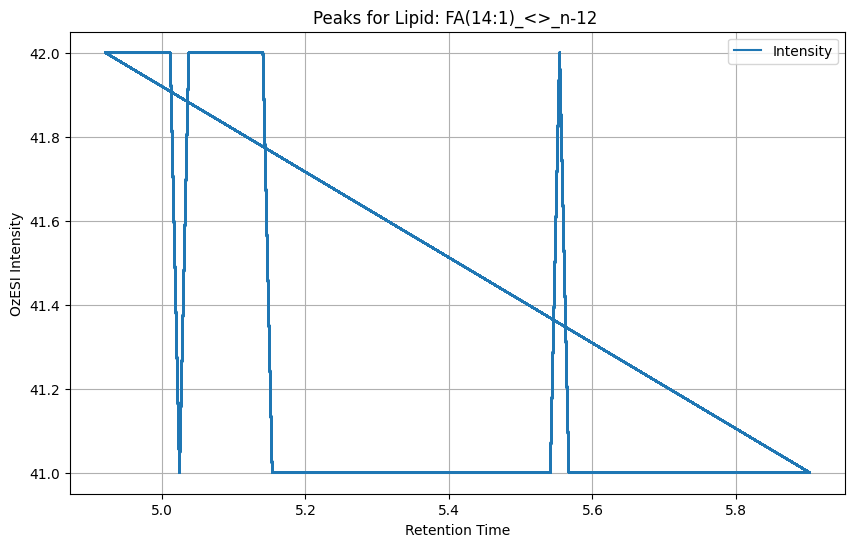

In [22]:
# Assuming you have already run the grouping and peak finding process as shown previously

# Initialize the LipidAnalysis class with the grouped DataFrame (already done previously)
lipid_analysis = LipidAnalysis(data=df_grouped)

# Plot data and peaks for a specific group
# Replace 'group_value' with the actual value you want to view
# For example, if you want to view peaks for a specific 'group_by_lipid' value

# You can get unique group values to decide which one to plot
unique_group_values = df_grouped['group_by_lipid'].unique()
print("Unique group_by_lipid values:", unique_group_values)

# Select one value to plot, for example the first one
group_value = unique_group_values[0]

# Plot the peaks for the selected group value
lipid_analysis.plot_data_and_peaks(
    group_type='group_by_lipid',  # Could be 'group_by_ion' or 'group_by_lipid'
    group_value=group_value,      # The specific group value to plot
    height=1000,                  # Minimum height of peaks
    width=None,                   # Minimum width of peaks (can be None)
    rel_height=0.5                # Relative height for peak width calculation
)


# plot full spectrum to get an idea of where data is

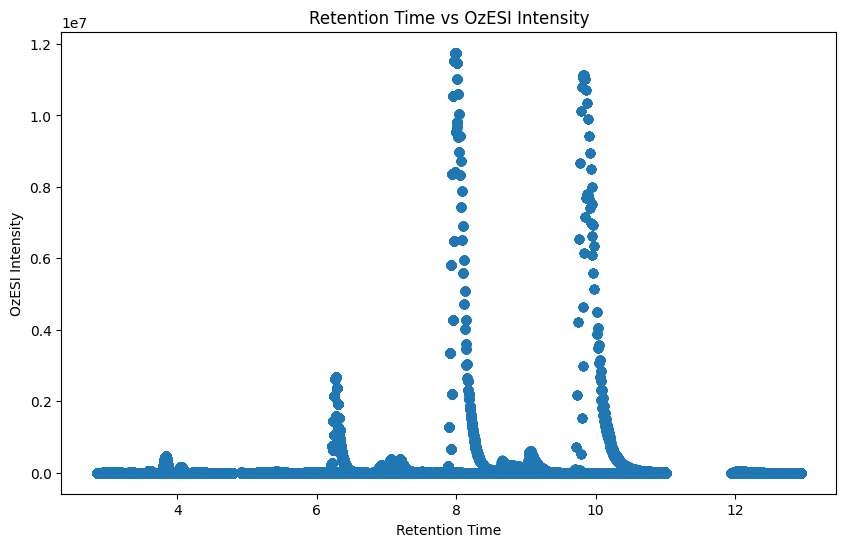

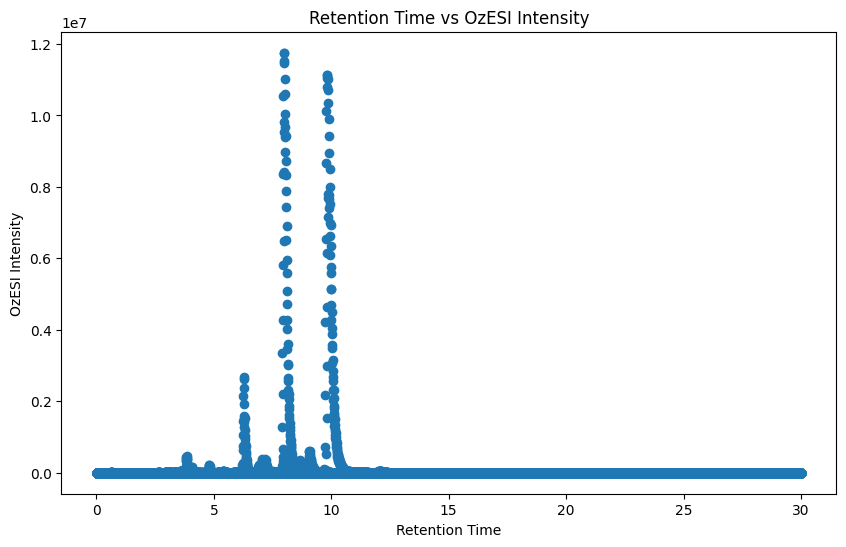

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

class Plot:
    def __init__(self):
        pass
    
    def plot_full_spectrum(self, df):
        # Read the CSV file into a DataFrame
        
        # Plot the data
        plt.figure(figsize=(10, 6))
        plt.scatter(df['Retention_Time'], df['OzESI_Intensity'])
        plt.xlabel('Retention Time')
        plt.ylabel('OzESI Intensity')
        plt.title('Retention Time vs OzESI Intensity')
        plt.show()

# Instantiate the class
plotter = Plot()

# Call the method with the path to your CSV file
plotter.plot_full_spectrum(df_grouped)
plotter.plot_full_spectrum(OzESI_df)
# # Load the DataFrame
# df2 = pd.read_csv('OzON_results_testing03Jul24_v2.csv')

# Display the DataFrame


# Peak analyssi class update

# Lipid Analysis - added tqdm

In [15]:
import pandas as pd
from scipy.signal import find_peaks, peak_widths
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

class LipidAnalysis:
    def __init__(self, data):
        self.data = data
        self.height = 1000
        self.width = None
        self.rel_height = 0.5

    @staticmethod
    def create_folder(directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def set_parameters(self, height=1000, width=None, rel_height=0.5):
        self.height = height
        self.width = width
        self.rel_height = rel_height

    def find_lipid_peaks(self, data=None, file_path=None, peak_analysis_csv=None, user_input="OFF"):
        if user_input not in ["ON", "OFF"]:
            raise ValueError("user_input must be 'ON' or 'OFF'")
        
        if data is None and file_path is None:
            raise ValueError("Either data (DataFrame) or file_path (CSV file path) must be provided")
        
        if data is not None:
            self.data = data
        else:
            self.data = pd.read_csv(file_path)

        peak_data = []

        for filter_col in ['group_by_ion', 'group_by_lipid']:
            unique_groups = self.data[filter_col].unique()

            for group in tqdm(unique_groups, desc=f"Processing {filter_col} groups"):
                group_data = self.data[self.data[filter_col] == group]
                peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=self.height, width=self.width)
                results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=self.rel_height)

                # Calculate sampling interval
                retention_times = group_data['Retention_Time'].values
                if len(retention_times) > 1:
                    sampling_interval = retention_times[1] - retention_times[0]
                else:
                    sampling_interval = 1  # Fallback value in case there's only one retention time

                #print(f"Sampling Interval: {sampling_interval}")

                for i, peak in enumerate(peaks):
                    metadata = group_data.iloc[peak][['Parent_Ion', 'Product_Ion', 'Sample', 'Species', 'group_by_lipid', 'group_by_ion', 'Biology', 'Genotype', 'Cage', 'Mouse', 'Lipid']]
                    left_ip = results_half[2][i]
                    right_ip = results_half[3][i]
                    left_time = group_data['Retention_Time'].iloc[int(left_ip)]
                    right_time = group_data['Retention_Time'].iloc[int(right_ip)]
                    width_in_time = right_time - left_time

                    fwhm = results_half[0][i] * sampling_interval

                    #print(f"{filter_col}: {metadata[filter_col]} - Peak {i}: Start Time = {left_time}, End Time = {right_time}, Width = {width_in_time}, FWHM = {fwhm}")

                    peak_data.append({
                        'Lipid': metadata['Lipid'],
                        'Retention_Time': group_data.iloc[peak]['Retention_Time'],
                        'OzESI_Intensity': group_data.iloc[peak]['OzESI_Intensity'],
                        'group_by_ion': metadata['group_by_ion'],
                        'group_by_lipid': metadata['group_by_lipid'],
                        'Sample_ID': group_data.iloc[peak]['Sample_ID'],
                        'Transition': group_data.iloc[peak]['Transition'],
                        'Sample': metadata['Sample'],
                        'Parent_Ion': metadata['Parent_Ion'],
                        'Product_Ion': metadata['Product_Ion'],
                        'Species': metadata['Species'],
                        'Class': group_data.iloc[peak]['Class'],
                        'Possible_Lipids': group_data.iloc[peak]['Possible_Lipids'],
                        'Biology': metadata['Biology'],
                        'Genotype': metadata['Genotype'],
                        'Cage': metadata['Cage'],
                        'Mouse': metadata['Mouse'],
                        'Peak_Height': properties['peak_heights'][i],
                        'FWHM': fwhm,
                        'Peak_Width': width_in_time,
                        'Peak_Area': properties['peak_heights'][i] * width_in_time,
                        'Filter_Column': filter_col  # Track which column was used for filtering
                    })

        peaks_df = pd.DataFrame(peak_data)

        # Ensure the directory for the CSV file exists
        csv_data_folder = os.path.dirname(peak_analysis_csv)
        self.create_folder(csv_data_folder)

        # Save the DataFrame to the CSV file
        peaks_df.to_csv(peak_analysis_csv, index=False)
        return peaks_df

    def plot_peaks(self, peaks_df, project_results=None, file_name_to_save=None):
        unique_lipids = peaks_df['Lipid'].unique()

        for lipid in unique_lipids:
            lipid_data = peaks_df[peaks_df['Lipid'] == lipid]
            plt.figure(figsize=(10, 6))

            plt.plot(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], label=lipid)
            plt.scatter(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], color='red')

            for _, row in lipid_data.iterrows():
                plt.annotate(f"Peak Height: {row['Peak_Height']:.2f}\nFWHM: {row['FWHM']:.2f}\nArea: {row['Peak_Area']:.2f}",
                             (row['Retention_Time'], row['OzESI_Intensity']),
                             textcoords="offset points",
                             xytext=(0, 10),
                             ha='center')

            plt.title(f"Peaks for Lipid: {lipid}")
            plt.xlabel('Retention Time')
            plt.ylabel('OzESI Intensity')
            plt.legend()
            plt.grid(True)

            plot_folder = f'{project_results}plots/'
            self.create_folder(plot_folder)
            plt.savefig(f"{plot_folder}{file_name_to_save}_{lipid}_peaks.png")
            plt.close()

    def plot_data_and_peaks(self, group_type, group_value, height=1000, width=None, rel_height=0.5):
        if group_type not in ['group_by_ion', 'group_by_lipid']:
            raise ValueError(f"group_type must be 'group_by_ion' or 'group_by_lipid'")

        if group_type not in self.data.columns:
            raise ValueError(f"group_type '{group_type}' is not a valid column in the data")

        group_data = self.data[self.data[group_type] == group_value]
        peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=height, width=width)
        results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=rel_height)

        plt.figure(figsize=(10, 6))
        plt.plot(group_data['Retention_Time'], group_data['OzESI_Intensity'], label='Intensity')
        plt.scatter(group_data['Retention_Time'].iloc[peaks], group_data['OzESI_Intensity'].iloc[peaks], color='red')

        # Annotate peaks
        for i, peak in enumerate(peaks):
            left_ip = results_half[2][i]
            right_ip = results_half[3][i]
            left_time = group_data['Retention_Time'].iloc[int(left_ip)]
            right_time = group_data['Retention_Time'].iloc[int(right_ip)]
            width_in_time = right_time - left_time

            fwhm = results_half[0][i] * (group_data['Retention_Time'].values[1] - group_data['Retention_Time'].values[0])

            plt.annotate(f"Peak Height: {properties['peak_heights'][i]:.2f}\nFWHM: {fwhm:.2f}\nArea: {properties['peak_heights'][i] * width_in_time:.2f}",
                        (group_data['Retention_Time'].iloc[peak], group_data['OzESI_Intensity'].iloc[peak]),
                        textcoords="offset points",
                        xytext=(0, 10),
                        ha='center')

        if group_type == 'group_by_lipid':
            lipid_value = group_data['Lipid'].iloc[0] if 'Lipid' in group_data.columns else 'Unknown'
            plot_title = f"Lipid: {lipid_value}"
        else:  # group_type == 'group_by_ion'
            parent_ion_value = group_data['Parent_Ion'].iloc[0] if 'Parent_Ion' in group_data.columns else 'Unknown'
            plot_title = f"Parent Ion: {parent_ion_value}"

        plt.title(f"Peaks for {plot_title}")
        plt.xlabel('Retention Time')
        plt.ylabel('OzESI Intensity')
        plt.legend()
        plt.grid(True)
        plt.show()


# Example usage:
# Initialize your LipidAnalysis class with some data
analysis = LipidAnalysis(df_grouped)

# Set parameters before calling the find_lipid_peaks method
analysis.set_parameters(height=1000, width=None, rel_height=0.5)

peak_analysis_csv = f"{csv_data_folder}{project_data_name}_PeakAnalysis_{mode}.csv"  # Path to the PeakAnalysis output CSV file

# Call the find_lipid_peaks method
peaks_df = analysis.find_lipid_peaks(data=df_grouped, peak_analysis_csv=peak_analysis_csv, user_input=mode)


Processing group_by_ion groups:   6%|▌         | 5/86 [00:00<00:08,  9.99it/s]

Processing group_by_lipid groups: 100%|██████████| 880/880 [00:19<00:00, 44.51it/s] 


In [16]:
peaks_df

Lipid  Retention_Time  OzESI_Intensity  group_by_ion  \
0         FA(13:1)_<>_n-8         3.072867          10876.0             6   
1         FA(13:1)_<>_n-8         3.072867          10876.0             6   
2      FA(15:3)_<FF>_n-10         3.072867          10876.0             6   
3          FA(8:1)_<>_n-3         3.085800           9690.0             6   
4          FA(8:1)_<>_n-3         3.085800           9690.0             6   
...                    ...             ...              ...           ...   
38975    FA(15:2)_<B>_n-2         3.702500           1425.0            41   
38976    FA(15:2)_<F>_n-2         3.753967           2677.0            43   
38977    FA(15:2)_<F>_n-2         3.857333           3615.0            43   
38978    FA(15:2)_<F>_n-2         3.753967           2677.0            43   
38979    FA(15:2)_<F>_n-2         3.857333           3615.0            43   

       group_by_lipid                                          Sample_ID  \
0                  48  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
1                  48  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
2                 152  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
3                 860  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
4                 860  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...   
...               ...                                                ...   
38975              99  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
38976             119  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
38977             119  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
38978             119  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   
38979             119  11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...   

           Transition               Sample  Parent_Ion  Product_Ion  ...  \
0      283.2 -> 183.0   WT_m1_cereb_FAD245       283.2        183.0  ...   
1      283.2 -> 183.0   WT_m1_cereb_FAD245       283.2        183.0  ...   
2      283.2 -> 183.0   WT_m1_cereb_FAD245       283.2        183.0  ...   
3      283.2 -> 183.0   WT_m1_cereb_FAD245       283.2        183.0  ...   
4      283.2 -> 183.0   WT_m1_cereb_FAD245       283.2        183.0  ...   
...               ...                  ...         ...          ...  ...   
38975  393.4 -> 183.0  WT_m1_cortex_FAD245       393.4        183.0  ...   
38976  395.3 -> 183.0  WT_m1_cortex_FAD245       395.3        183.0  ...   
38977  395.3 -> 183.0  WT_m1_cortex_FAD245       395.3        183.0  ...   
38978  395.3 -> 183.0  WT_m1_cortex_FAD245       395.3        183.0  ...   
38979  395.3 -> 183.0  WT_m1_cortex_FAD245       395.3        183.0  ...   

                                         Possible_Lipids Biology Genotype  \
0      FA(6:0) | FA(8:1)_<>_n-3 | FA(9:1)_<>_n-4 | FA...   cereb       WT   
1      FA(6:0) | FA(8:1)_<>_n-3 | FA(9:1)_<>_n-4 | FA...   cereb       WT   
2      FA(6:0) | FA(8:1)_<>_n-3 | FA(9:1)_<>_n-4 | FA...   cereb       WT   
3      FA(6:0) | FA(8:1)_<>_n-3 | FA(9:1)_<>_n-4 | FA...   cereb       WT   
4      FA(6:0) | FA(8:1)_<>_n-3 | FA(9:1)_<>_n-4 | FA...   cereb       WT   
...                                                  ...     ...      ...   
38975  FA(15:2)_<B>_n-2 | FA(15:3)_<BF>_n-2 | FA(16:2...  cortex       WT   
38976  FA(14:0) | FA(15:1)_<>_n-2 | FA(15:2)_<F>_n-2 ...  cortex       WT   
38977  FA(14:0) | FA(15:1)_<>_n-2 | FA(15:2)_<F>_n-2 ...  cortex       WT   
38978  FA(14:0) | FA(15:1)_<>_n-2 | FA(15:2)_<F>_n-2 ...  cortex       WT   
38979  FA(14:0) | FA(15:1)_<>_n-2 | FA(15:2)_<F>_n-2 ...  cortex       WT   

         Cage Mouse Peak_Height      FWHM  Peak_Width     Peak_Area  \
0      FAD245    m1     10876.0  0.049973   -3.462667 -37659.962667   
1      FAD245    m1     10876.0  0.049954   -1.692567 -18408.355067   
2      FAD245    m1     10876.0  0.073581    0.077517    843.071267   
3      FAD245    m1      9690.0  0.026236   -3.462667 -33553.

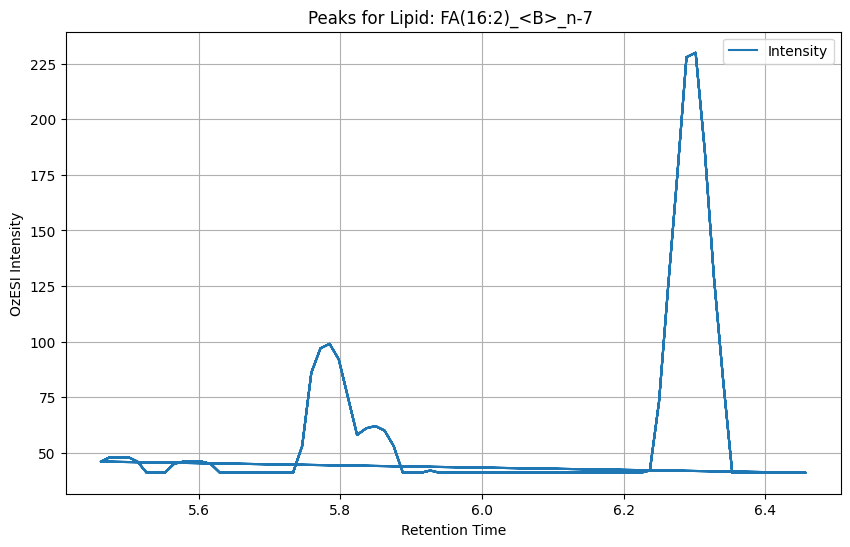

In [18]:

analysis.plot_data_and_peaks(group_type='group_by_lipid', group_value=208, height=500, width=2, rel_height=0.5)

# PEAK ANALYSIS CLASS

In [19]:

class PeakAnalysis:
    def __init__(self, raw_data_csv, mode):
        self.data = pd.read_csv(raw_data_csv)
        self.mode = mode

    def find_lipid_peaks(self, use_match_group=True, height=1000, width=None, rel_height=0.5, project_results=None, file_name_to_save=None, user_input="OFF"):
        if user_input not in ["ON", "OFF"]:
            raise ValueError("user_input must be 'ON' or 'OFF'")
        
        filter_col = 'group_by_ion' if use_match_group else 'group_by_lipid'
        unique_groups = self.data[filter_col].unique()
        peak_data = []

        for group in unique_groups:
            group_data = self.data[self.data[filter_col] == group]
            peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=height, width=width)
            results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=rel_height)

            # Calculate sampling interval
            retention_times = group_data['Retention_Time'].values
            if len(retention_times) > 1:
                sampling_interval = retention_times[1] - retention_times[0]
            else:
                sampling_interval = 1  # Fallback value in case there's only one retention time

            print(f"Sampling Interval: {sampling_interval}")

            for i, peak in enumerate(peaks):
                metadata = group_data.iloc[peak][['Parent_Ion', 'Product_Ion', 'Species', 'group_by_lipid', 'group_by_ion', 'Biology', 'Genotype', 'Cage', 'Mouse', 'Lipid']]
                left_ip = results_half[2][i]
                right_ip = results_half[3][i]
                left_time = group_data['Retention_Time'].iloc[int(left_ip)]
                right_time = group_data['Retention_Time'].iloc[int(right_ip)]
                width_in_time = right_time - left_time

                fwhm = results_half[0][i] * sampling_interval

                print(f"group_by_lipid: {metadata['group_by_lipid']} - Peak {i}: Start Time = {left_time}, End Time = {right_time}, Width = {width_in_time}, FWHM = {fwhm}")

                peak_data.append({
                    'Lipid': metadata['Lipid'],
                    'Retention_Time': group_data.iloc[peak]['Retention_Time'],
                    'OzESI_Intensity': group_data.iloc[peak]['OzESI_Intensity'],
                    'group_by_ion': metadata['group_by_ion'],
                    'group_by_lipid': metadata['group_by_lipid'],
                    'Sample_ID': group_data.iloc[peak]['Sample_ID'],
                    'Sample': metadata[peak]['Sample'],
                    'Parent_Ion': metadata['Parent_Ion'],
                    'Product_Ion': metadata['Product_Ion'],
                    'Species': metadata['Species'],
                    'Biology': metadata['Biology'],
                    'Genotype': metadata['Genotype'],
                    'Cage': metadata['Cage'],
                    'Mouse': metadata['Mouse'],
                    'Class': metadata[peak]['Class'],
                    'Peak_Height': properties['peak_heights'][i],
                    'FWHM': fwhm,
                    'Peak_Width': width_in_time,
                    'Peak_Area': properties['peak_heights'][i] * width_in_time
                })

        peaks_df = pd.DataFrame(peak_data)

        csv_data_folder = f'{project_results}csv_data/'
        create_folder(csv_data_folder)

        output_csv = f"{csv_data_folder}{file_name_to_save}_PeakAnalysis_{user_input}.csv"
        peaks_df.to_csv(output_csv, index=False)
        return peaks_df

    def plot_data_and_peaks(self, raw_data_csv, peak_analysis_csv, group_value, group_type='group_by_ion', height=50000, width=None, rel_height=0.5):
        # Read the raw data CSV file into a DataFrame
        raw_df = pd.read_csv(raw_data_csv)

        # Read the peak analysis CSV file into a DataFrame
        peak_df = pd.read_csv(peak_analysis_csv)

        if group_type not in ['group_by_ion', 'group_by_lipid']:
            raise ValueError("group_type must be 'group_by_ion' or 'group_by_lipid'")

        # Filter the DataFrame based on the specified group value
        filtered_raw_df = raw_df[raw_df[group_type] == group_value]
        filtered_peak_df = peak_df[peak_df[group_type] == group_value]

        if filtered_raw_df.empty:
            print(f"No data found for group {group_value} ({group_type})")
            return

        # Calculate the sampling interval
        retention_times = filtered_raw_df['Retention_Time'].values
        sampling_interval = retention_times[1] - retention_times[0]

        # Plot the full spectrum data
        plt.figure(figsize=(10, 6))
        plt.plot(filtered_raw_df['Retention_Time'], filtered_raw_df['OzESI_Intensity'], color='blue', label='Intensity vs. Retention Time')
        if not filtered_raw_df.empty:
            first_peak = filtered_raw_df.iloc[0]
            title_info = f"{first_peak['Lipid']}, MG {first_peak['group_by_ion']}, GS {first_peak['group_by_lipid']}, {first_peak['Parent_Ion']}, {first_peak['Species']}, {first_peak['Biology']}, {first_peak['Genotype']}, {first_peak['Cage']}, {first_peak['Mouse']}"
            plt.title(title_info)
        plt.xlabel('Retention Time')
        plt.ylabel('OzESI Intensity')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot the peak data
        peaks, properties = find_peaks(filtered_raw_df['OzESI_Intensity'], height=height, width=width)
        results_half = peak_widths(filtered_raw_df['OzESI_Intensity'], peaks, rel_height=rel_height)

        # Convert peak widths to retention time units
        left_ips = results_half[2]
        right_ips = results_half[3]
        peak_widths_in_time = (right_ips - left_ips) * sampling_interval

        plt.figure(figsize=(10, 6))
        plt.plot(filtered_raw_df['Retention_Time'], filtered_raw_df['OzESI_Intensity'], color='gray', alpha=0.5, label='Full Data')
        plt.scatter(filtered_raw_df.iloc[peaks]['Retention_Time'], filtered_raw_df.iloc[peaks]['OzESI_Intensity'], color='red', label='Peaks')
        
        # Plot peak widths using the converted time units and vertical lines for start and stop times
        for left_ip, right_ip, height in zip(left_ips, right_ips, results_half[1]):
            left_time = filtered_raw_df['Retention_Time'].iloc[int(left_ip)]
            right_time = filtered_raw_df['Retention_Time'].iloc[int(right_ip)]
            plt.hlines(y=height, xmin=left_time, xmax=right_time, color='blue', linestyle='--', label='Peak Width')
            plt.axvline(x=left_time, color='green', linestyle=':', label='Peak Start' if 'Peak Start' not in plt.gca().get_legend_handles_labels()[1] else "")
            plt.axvline(x=right_time, color='purple', linestyle=':', label='Peak Stop' if 'Peak Stop' not in plt.gca().get_legend_handles_labels()[1] else "")

        plt.xlabel('Retention Time')
        plt.ylabel('OzESI Intensity')
        plt.legend()
        plt.title(f"Peaks for Group {group_value} ({group_type})")
        plt.grid(True)
        plt.show()


In [78]:
# Create an instance of PeakAnalysis
raw_data_csv_hard = './Projects/AMP/results/onfly_test/csv_data/parsed_data_RawDataParser_test.csv'
mode = "ON"
peak_analysis = OzESI.PeakAnalysis(raw_data_csv_hard, mode)

In [79]:
# Perform peak analysis
peaks_df = peak_analysis.find_lipid_peaks(use_match_group=True, height=5, width=2, rel_height=0.5, project_results=Project_results, file_name_to_save=file_name_to_save, user_input=mode)


Sampling Interval: 0.012900000000000002
Group_Sample: 4 - Peak 0: Start Time = 0.1149166666666666, End Time = 0.1795166666666666, Width = 0.0646, FWHM = 0.06055030708478303
Group_Sample: 4 - Peak 1: Start Time = 0.3087166666666667, End Time = 0.33455, Width = 0.02583333333333332, FWHM = 0.025800000000000003
Group_Sample: 4 - Peak 2: Start Time = 0.45085, End Time = 0.4896, Width = 0.03875000000000001, FWHM = 0.045148769788289064
Group_Sample: 4 - Peak 3: Start Time = 0.45085, End Time = 0.4896, Width = 0.03875000000000001, FWHM = 0.045148769788289064
Group_Sample: 4 - Peak 4: Start Time = 0.5800500000000001, End Time = 0.6188166666666667, Width = 0.038766666666666616, FWHM = 0.033236608171816735
Group_Sample: 4 - Peak 5: Start Time = 0.6834166666666667, End Time = 0.7738666666666667, Width = 0.09045000000000003, FWHM = 0.09593845793929846
Group_Sample: 4 - Peak 6: Start Time = 0.9159833333333334, End Time = 0.9676666666666668, Width = 0.051683333333333414, FWHM = 0.05765199757117562
Gr

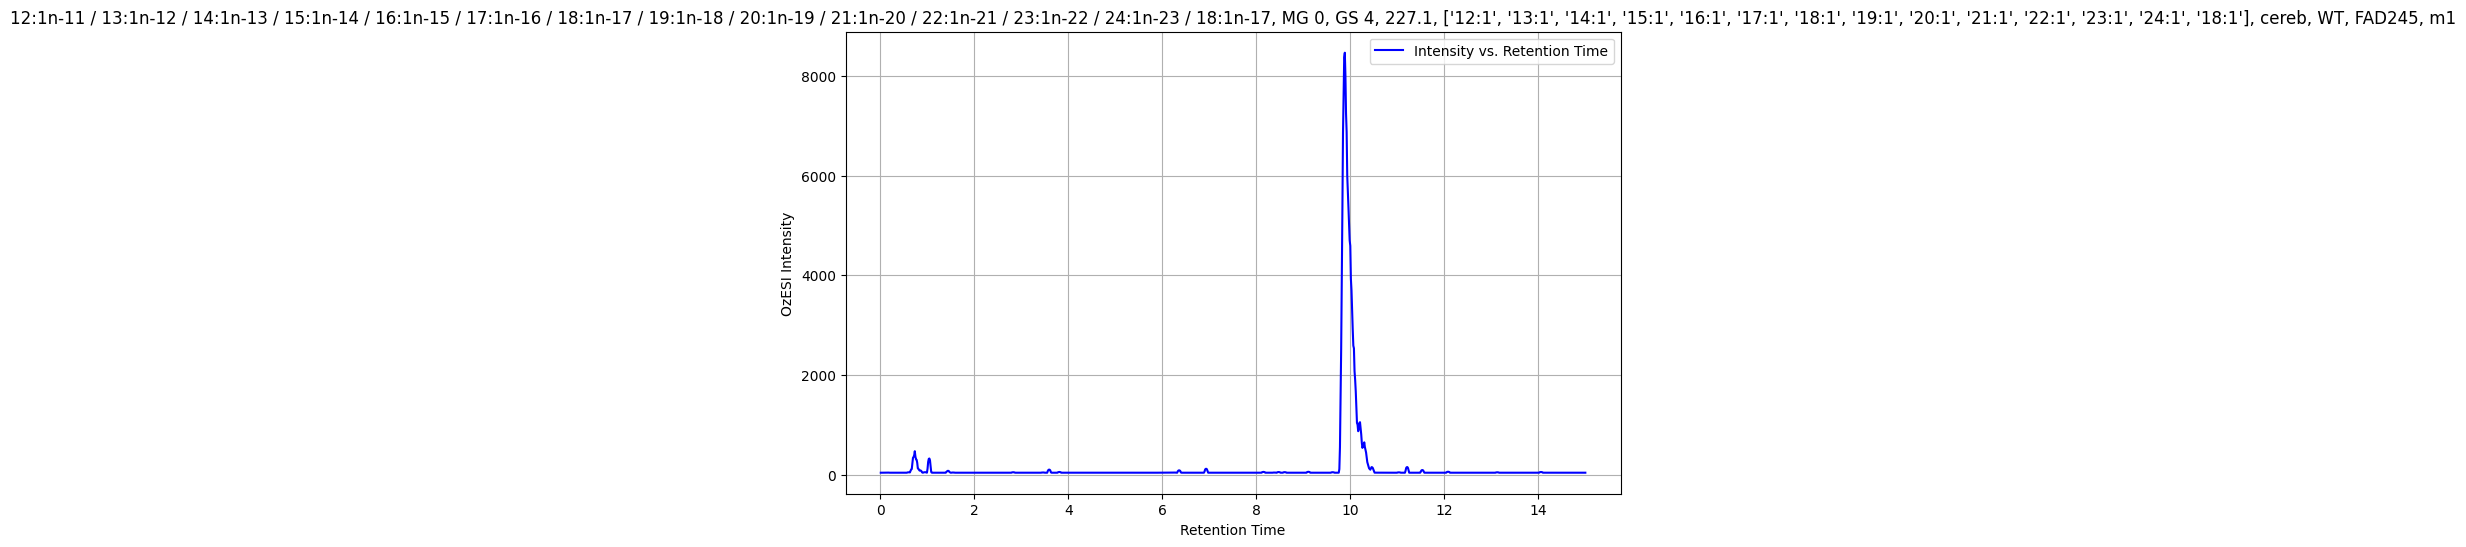

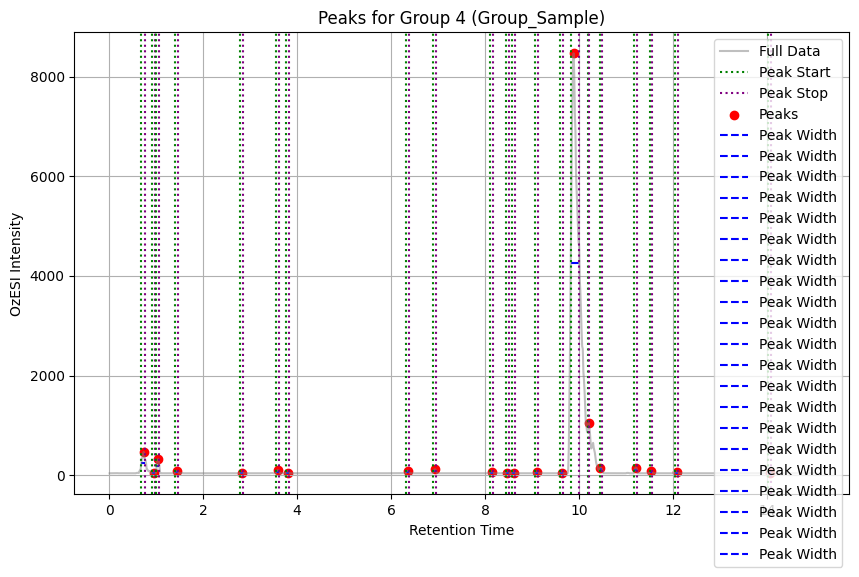

In [82]:
# Plot data and peaks for a specific group
peak_analysis.plot_data_and_peaks(raw_data_csv_hard, peak_analysis_csv,group_type='Group_Sample', group_value=4, height=50, width=2, rel_height=0.5)

In [83]:
peaks_df

Lipid  Retention_Time  \
0     12:1n-11 / 13:1n-12 / 14:1n-13 / 15:1n-14 / 16...        0.153667   
1     12:1n-11 / 13:1n-12 / 14:1n-13 / 15:1n-14 / 16...        0.321633   
2     12:1n-11 / 13:1n-12 / 14:1n-13 / 15:1n-14 / 16...        0.463767   
3     12:1n-11 / 13:1n-12 / 14:1n-13 / 15:1n-14 / 16...        0.489600   
4     12:1n-11 / 13:1n-12 / 14:1n-13 / 15:1n-14 / 16...        0.605900   
...                                                 ...             ...   
5924                                               24:1       14.263750   
5925                                               24:1       14.457550   
5926                                               24:1       14.586750   
5927                                               24:1       14.741800   
5928                                               24:1       14.909750   

      OzESI_Intensity  Match_Group  Group_Sample  \
0           44.160004            0             4   
1           41.280003            0             4   
2           41.420002            0             4   
3           41.420002            0             4   
4           49.780003            0             4   
...               ...          ...           ...   
5924        41.420002           53            49   
5925        41.460003           53            49   
5926        41.480003           53            49   
5927        41.400002           53            49   
5928        41.540005           53            49   

                                              Sample_ID  Parent_Ion  \
0     11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...       227.1   
1     11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...       227.1   
2     11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...       227.1   
3     11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...       227.1   
4     11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...       227.1   
...                                                 ...         ...   
5924  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...       533.5   
5925  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...       533.5   
5926  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...       533.5   
5927  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...       533.5   
5928  11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...       533.5   

      Product_Ion                                                FAC Biology  \
0           183.0  ['12:1', '13:1', '14:1', '15:1', '16:1', '17:1...   cereb   
1           183.0  ['12:1', '13:1', '14:1', '15:1', '16:1', '17:1...   cereb   
2           183.0  ['12:1', '13:1', '14:1', '15:1', '16:1', '17:1...   cereb   
3           183.0  ['12:1', '13:1', '14:1', '15:1', '16:1', '17:1...   cereb   
4           183.0  ['12:1', '13:1', '14:1', '15:1', '16:1', '17:1...   cereb   
...           ...                                                ...     ...   
5924        183.0                                           ['24:1']   cereb   
5925        183.0                                           ['24:1']   cereb   
5926        183.0                                           ['24:1']   cereb   
5927        183.0                                           ['24:1']   cereb   
5928        183.0                                           ['24:1']   cereb   

     Genotype    Cage Mouse  Peak_Height      FWHM  Peak_Width  Peak_Area  
0          WT  FAD245    m1    44.160004  0.060550    0.064600   2.852736  
1          WT  FAD245    m1    41.280003  0.025800    0.025833   1.066400  
2          WT  FAD245    m1    41.420002  0.045149    0.038750   1.605025  
3          WT  FAD245    m1    41.420002  0.045149    0.038750   1.605025  
4          WT  FAD245    m1    49.780003  0.033237    0.038767   1.929805  
...       ...     ...   ...          ...       ...         ...        ...  
5924       WT  FAD245    m1    41.420002  0.043056    0.038767   1.605715  
5925       WT  FAD245    m1    41.460003  0.090415    0.077517   3.213841  
5926       WT  FAD245    m

# Read in files on the fly - move to matchin lipid part later

In [84]:
import os
import pandas as pd
import re

def load_lipid_data(lipid_list, directory):
    lipid_dict = {}
    lipid_set = set(lipid_list)
    
    # Regular expression pattern to match filenames
    pattern = re.compile(r"FA\((\d+_\d+)\)_OzON_Database\.csv")
    
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            lipid = match.group(1).replace('_', ':')
            if lipid in lipid_set:
                filepath = os.path.join(directory, filename)
                df = pd.read_csv(filepath)
                lipid_dict[lipid] = df
                
    return lipid_dict

# Example usage
lipid_list = ['14:1', '16:1', '17:1', '18:1', '18:2', '18:3', '20:5']
directory = 'lipid_database/OzON_FA_Database_split/'  # Replace with your directory path

lipid_data = load_lipid_data(lipid_list, directory)

# Check the resulting dictionary
for lipid, df in lipid_data.items():
    print(f"{lipid}: DataFrame with shape {df.shape}")


14:1: DataFrame with shape (1, 19)
18:3: DataFrame with shape (3, 23)
18:1: DataFrame with shape (1, 23)
16:1: DataFrame with shape (1, 21)
18:2: DataFrame with shape (2, 23)
17:1: DataFrame with shape (1, 22)
20:5: DataFrame with shape (5, 25)
